In [4]:
# CELL 1 – HOW TO USE DAILY (Markdown rendered via code)

from IPython.display import Markdown, display
from IPython.display import HTML, display, Video

display(Markdown("""
### How to Use Daily (No Training!)
- Set a checkpoint episode (e.g., 200) in any “LOAD & EVALUATE” cell.
- Run only the “LOAD & EVALUATE” cells you need:
  - Merge-v0 (state)
  - highway-fast-v0 (state)
  - Transfer: merge → highway-fast-v0 (state)
  - Merge-v0 (CNN/observation)
  - Multi-Agent (shared policy)
- Videos will be saved in `Videos/` and auto-played in the notebook.
- You never need to retrain. If a checkpoint doesn’t exist, the loader will fall back to the latest available.
- All paths use `path_HW5` which defaults to your workspace; change it if needed.
"""))


### How to Use Daily (No Training!)
- Set a checkpoint episode (e.g., 200) in any “LOAD & EVALUATE” cell.
- Run only the “LOAD & EVALUATE” cells you need:
  - Merge-v0 (state)
  - highway-fast-v0 (state)
  - Transfer: merge → highway-fast-v0 (state)
  - Merge-v0 (CNN/observation)
  - Multi-Agent (shared policy)
- Videos will be saved in `Videos/` and auto-played in the notebook.
- You never need to retrain. If a checkpoint doesn’t exist, the loader will fall back to the latest available.
- All paths use `path_HW5` which defaults to your workspace; change it if needed.


In [5]:
# CELL 2 – IMPORTS & GLOBAL SETTINGS

import os
import re
import base64
import io
import glob
import sys
import time
import random
from pathlib import Path
from itertools import count
from collections import deque, namedtuple
from statistics import mean, median

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from scipy.stats import norm, t
from scipy.stats import ttest_ind
from tqdm import tqdm, trange

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim

import gymnasium as gym
import highway_env
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML, display
import imageio

plt.style.use('ggplot')
%matplotlib inline

# Base project path: default to this workspace; override via env var if needed
DEFAULT_BASE = str(Path.cwd().resolve())
path_HW5 = os.getenv("DRL_PROJECT_PATH", DEFAULT_BASE)
if not path_HW5.endswith(os.sep):
    path_HW5 += os.sep

# Ensure required directories
for subdir in ['Models', 'Data_Average_Reward', 'Videos', 'Images']:
    os.makedirs(os.path.join(path_HW5, subdir), exist_ok=True)

# Device selection
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} | Base path: {path_HW5}")

Using device: cpu | Base path: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\


In [6]:
# CELL 3 – HYPERPARAMETERS

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4

In [7]:
# CELL 4 – NEURAL NETWORKS (Linear + CNN)

class QNetwork_Linear(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super().__init__()
        torch.manual_seed(seed)
        self.net = nn.Sequential(
            nn.Linear(state_size, 125), nn.ReLU(),
            nn.Linear(125, 125), nn.ReLU(),
            nn.Linear(125, action_size)
        )
    def forward(self, state):
        return self.net(state)

class QNetwork_CNN(nn.Module):
    def __init__(self, action_size, seed):
        super().__init__()
        torch.manual_seed(seed)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten()
        )
        # Avoid LazyLinear: fixed in_features for stability with checkpoints
        self.head = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, action_size)
        )
    def forward(self, state):
        return self.head(self.features(state))

In [8]:
# CELL 5 – REPLAY BUFFER

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state","action","reward","next_state","done"])
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [9]:
# CELL 6 – AGENT (epsilon-greedy; soft-update fixed)

class Agent:
    def __init__(self, state_size, action_size, network_type, seed):
        self.state_size = state_size
        self.action_size = action_size
        random.seed(seed)
        self.network_type = network_type.lower()

        # Initialize local/target networks
        if self.network_type == 'linear':
            self.qnetwork_local = QNetwork_Linear(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork_Linear(state_size, action_size, seed).to(device)
        else:
            self.qnetwork_local = QNetwork_CNN(action_size, seed).to(device)
            self.qnetwork_target = QNetwork_CNN(action_size, seed).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

        # Stable resize for observation (screen) inputs
        self.resize = T.Compose([
            T.ToPILImage(),
            T.Resize((80, 80), interpolation=Image.Resampling.BICUBIC),
            T.ToTensor()
        ])

    def get_screen(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.0
        screen = torch.from_numpy(screen).permute(2, 0, 1)  # HWC -> CHW
        return self.resize(screen).unsqueeze(0)  # [1, 3, H, W]

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        # Learn every UPDATE_EVERY steps if enough samples
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            self.learn(self.memory.sample())

    def act(self, state, eps=0.0):
        # Epsilon-greedy action
        if self.network_type == 'linear':
            state_t = torch.from_numpy(state).float().unsqueeze(0).to(device)
        else:
            state_t = state.to(device)  # already [1, 3, H, W]

        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_t)
        self.qnetwork_local.train()

        if random.random() > eps:
            # Greedy action from Q-values
            return int(np.argmax(action_values.cpu().data.numpy()))
        # Random exploration
        return int(random.choice(np.arange(self.action_size)))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        with torch.no_grad():
            q_targets_next = self.qnetwork_target(next_states).max(1, keepdim=True)[0]
            q_targets = rewards + GAMMA * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1.0)
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    @staticmethod
    def soft_update(local_model, target_model, tau):
        # Polyak update: θ_target ← τ θ_local + (1-τ) θ_target
        with torch.no_grad():
            for tp, lp in zip(target_model.parameters(), local_model.parameters()):
                tp.data.copy_(tau * lp.data + (1.0 - tau) * tp.data)

In [10]:
# CELL 7 – DQN TRAINER (state + observation) WITH EVALUATION

class DQN:
    def __init__(self, env, env_name, model_path, data_path, network_type,
                 env_name_source=None, model_path_source=None, transfer_episode=None):
        self.env = env.unwrapped
        self.env_name = env_name
        self.model_path = model_path
        self.data_path = data_path
        self.network_type = network_type.lower()
        self.env_name_source = env_name_source
        self.model_path_source = model_path_source
        self.transfer_episode = transfer_episode

        self.df_reward = pd.DataFrame()
        self.seed = [0, 5, 11, 123, 487]
        self.policy_freq = int(self.env.config.get('policy_frequency', 10))
        self.obs_cfg = dict(self.env.config.get('observation', {}))

    def _make_eval_env(self, name_prefix=None):
        env = gym.make(self.env_name, render_mode='rgb_array')
        cfg = {"policy_frequency": self.policy_freq, "observation": self.obs_cfg}
        if hasattr(env, "configure"):
            env.configure(cfg)
        else:
            env.unwrapped.config.update(cfg)
        env.reset()
        if name_prefix:
            videos_dir = os.path.join(path_HW5, "Videos")
            env = RecordVideo(env, video_folder=videos_dir,
                              name_prefix=name_prefix, episode_trigger=lambda ep: True)
        return env

    def train_with_state(self, n_iteration, n_training_episodes, max_step,
                         eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print(f"Training agent with state for {self.env_name}...")
        if n_iteration[0] != 1:
            prev = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
            if os.path.exists(prev):
                self.df_reward = pd.read_excel(prev)

        for iter in tqdm(n_iteration, desc="Iterations"):
            episodes_reward = []
            state0, _ = self.env.reset()
            state_size = int(np.prod(state0.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])

            # Optional: transfer initialization
            if self.env_name_source and self.model_path_source and self.transfer_episode:
                lp = os.path.join(self.model_path_source, f'Models_Run_{iter}',
                                  f'checkpoint_dqn_state_{self.env_name_source}_local_{self.transfer_episode}.pth')
                tp = os.path.join(self.model_path_source, f'Models_Run_{iter}',
                                  f'checkpoint_dqn_state_{self.env_name_source}_target_{self.transfer_episode}.pth')
                if os.path.exists(lp) and os.path.exists(tp):
                    agent.qnetwork_local.load_state_dict(torch.load(lp, map_location=device))   # Load local network
                    agent.qnetwork_target.load_state_dict(torch.load(tp, map_location=device))  # Load target network
                else:
                    print(f"Warning: transfer checkpoints missing: {lp} or {tp}")

            os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
            eps = eps_start

            for episode_num in trange(1, n_training_episodes + 1, desc=f"Iter {iter} Episodes", leave=False):
                eps = max(eps_end, eps_decay * eps)
                state, _ = self.env.reset()
                total_reward = 0.0
                for _ in range(max_step):
                    action = agent.act(state.ravel(), eps)  # Epsilon-greedy action
                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    total_reward += reward
                    agent.step(state.ravel(), action, reward, next_state.ravel(), terminated or truncated)
                    if terminated or truncated:
                        break
                    state = next_state
                episodes_reward.append(total_reward)

                if episode_num % 20 == 0:
                    self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
                    self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)

                if episode_num % 100 == 0:
                    torch.save(agent.qnetwork_local.state_dict(),
                               os.path.join(self.model_path, f'Models_Run_{iter}',
                                            f'checkpoint_dqn_state_{self.env_name}_local_{episode_num}.pth'))
                    torch.save(agent.qnetwork_target.state_dict(),
                               os.path.join(self.model_path, f'Models_Run_{iter}',
                                            f'checkpoint_dqn_state_{self.env_name}_target_{episode_num}.pth'))

            self.df_reward[f'Run_{iter}'] = episodes_reward
            self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
            tmp = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
            if os.path.exists(tmp):
                os.remove(tmp)
        return self.df_reward

    def train_with_observation(self, n_iteration, n_training_episodes, max_step,
                               eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print(f"Training agent with observation for {self.env_name}...")
        if self.network_type != "cnn":
            raise ValueError("Use network_type='cnn' for observation training")

        if n_iteration[0] != 1:
            prev = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
            if os.path.exists(prev):
                self.df_reward = pd.read_excel(prev)

        for iter in tqdm(n_iteration, desc="Iterations"):
            episodes_reward = []
            state_size = int(np.prod(self.env.observation_space.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])

            os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
            eps = eps_start

            for episode_num in trange(1, n_training_episodes + 1, desc=f"Iter {iter} Episodes", leave=False):
                eps = max(eps_end, eps_decay * eps)
                self.env.reset()
                last_screen = agent.get_screen(self.env.render())
                current_screen = agent.get_screen(self.env.render())
                obs = current_screen - last_screen

                total_reward = 0.0
                for _ in range(max_step):
                    action = agent.act(obs, eps)  # Epsilon-greedy action
                    _, reward, terminated, truncated, _ = self.env.step(action)
                    total_reward += reward
                    last_screen = current_screen
                    current_screen = agent.get_screen(self.env.render())
                    nxt = current_screen - last_screen
                    agent.step(obs.cpu().numpy(), action, reward, nxt.cpu().numpy(), terminated or truncated)
                    if terminated or truncated:
                        break
                    obs = nxt
                episodes_reward.append(total_reward)

                if episode_num % 20 == 0:
                    self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
                    self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)

                if episode_num % 100 == 0:
                    torch.save(agent.qnetwork_local.state_dict(),
                               os.path.join(self.model_path, f'Models_Run_{iter}',
                                            f'checkpoint_dqn_observation_{self.env_name}_local_{episode_num}.pth'))
                    torch.save(agent.qnetwork_target.state_dict(),
                               os.path.join(self.model_path, f'Models_Run_{iter}',
                                            f'checkpoint_dqn_observation_{self.env_name}_target_{episode_num}.pth'))

            self.df_reward[f'Run_{iter}'] = episodes_reward
            self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
            tmp = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
            if os.path.exists(tmp):
                os.remove(tmp)
        return self.df_reward

    def evaluation(self, video_file, evaluate_type, iter_num, evaluate_episode_num,
                   use_saved_model=True, num_episodes=3, max_eval_steps=5000):
        """
        Evaluate with either 'state' or 'observation' policy; records videos to Videos/ with an auto prefix.
        """
        video_dir = os.path.dirname(video_file)
        os.makedirs(video_dir, exist_ok=True)

        s0, _ = self.env.reset()
        state_size = int(np.prod(s0.shape))
        action_size = self.env.action_space.n
        agent = Agent(state_size, action_size, self.network_type, seed=11)

        if use_saved_model:
            # Load local/target checkpoints based on mode
            local_name = f'checkpoint_dqn_{evaluate_type}_{self.env_name}_local_{evaluate_episode_num}.pth'
            target_name = f'checkpoint_dqn_{evaluate_type}_{self.env_name}_target_{evaluate_episode_num}.pth'
            lp = os.path.join(self.model_path, f'Models_Run_{iter_num}', local_name)
            tp = os.path.join(self.model_path, f'Models_Run_{iter_num}', target_name)
            if os.path.exists(lp) and os.path.exists(tp):
                agent.qnetwork_local.load_state_dict(torch.load(lp, map_location=device))   # Load local network
                agent.qnetwork_target.load_state_dict(torch.load(tp, map_location=device))  # Load target network
            else:
                print(f"Error: model files not found:\n{lp}\n{tp}")
                return None, 0

        eval_rewards = []
        crashes = 0
        # Construct a stable prefix for videos
        prefix = f"{self.env_name}_eval_ep"
        for ep in range(num_episodes):
            env_eval = self._make_eval_env(name_prefix=prefix)
            if evaluate_type == 'state':
                state, _ = env_eval.reset()
                done, steps, ep_r = False, 0, 0.0
                while not done and steps < max_eval_steps:
                    action = agent.act(state.ravel(), eps=0.0)  # Greedy action
                    state, reward, term, trunc, info = env_eval.step(action)
                    ep_r += reward
                    if isinstance(info, dict) and info.get('crashed', False):
                        crashes += 1
                    done = bool(term or trunc)
                    steps += 1
            else:
                env_eval.reset()
                last = agent.get_screen(env_eval.render())
                cur = agent.get_screen(env_eval.render())
                obs = cur - last
                done, steps, ep_r = False, 0, 0.0
                while not done and steps < max_eval_steps:
                    action = agent.act(obs, eps=0.0)  # Greedy action
                    _, reward, term, trunc, info = env_eval.step(action)
                    if isinstance(info, dict) and info.get('crashed', False):
                        crashes += 1
                    last = cur
                    cur = agent.get_screen(env_eval.render())
                    obs = cur - last
                    ep_r += reward
                    done = bool(term or trunc)
                    steps += 1
            env_eval.close()
            eval_rewards.append(ep_r)

        avg_reward = float(np.mean(eval_rewards)) if eval_rewards else 0.0
        crash_rate = crashes / max(1, num_episodes)
        print(f"Eval avg reward: {avg_reward:.2f} | crash rate: {crash_rate:.2%}")
        return avg_reward, crash_rate

In [11]:
# CELL 8 – VISUALIZATION HELPERS

class show_and_plot:
    def __init__(self): pass

    def show_video(self, directory, file_or_prefix):
        directory = directory if directory.endswith(os.sep) else directory + os.sep
        exact = os.path.join(directory, file_or_prefix)
        if os.path.exists(exact):
            mp4 = exact
        else:
            candidates = sorted(glob.glob(os.path.join(directory, f"{file_or_prefix}*.mp4")))
            if not candidates:
                any_mp4 = sorted(glob.glob(os.path.join(directory, "*.mp4")))
                print("Available videos:", [os.path.basename(x) for x in any_mp4])
                print(f"Not found: {exact}")
                return
            mp4 = candidates[-1]
        print(f"Displaying: {mp4}")
        with open(mp4, 'rb') as f:
            encoded = base64.b64encode(f.read()).decode('ascii')
        display(HTML(f'''
        <video alt="eval" autoplay loop controls style="height: 220px; width: 860px;">
            <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
        </video>
        '''))

    def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):
        n_iter, n_episode = episodes_rewards.shape
        smooth_reward = [np.mean(episodes_rewards[:, i*stride:i*stride+window], axis=1)
                         for i in range(int((n_episode - window)/stride) + 1)]
        smooth_reward = np.array(smooth_reward).T
        X = range(1, len(smooth_reward[0])*stride + 1, stride)
        x_bar = np.mean(smooth_reward, axis=0)
        sigma = np.std(smooth_reward, axis=0)
        SE = sigma / np.sqrt(max(1, n_iter))
        interval = 1 - alpha
        stat = t.interval(interval, df=max(1, n_iter-1))[1] if n_iter < 30 else norm.interval(interval)[1]
        ME = stat * SE
        ax.plot(X, x_bar, label=label)
        if n_iter >= 2:
            ax.fill_between(X, x_bar - ME, x_bar + ME, alpha=alpha)
        ax.set_xlabel("Episodes")
        ax.set_ylabel("Average Reward")
        ax.set_title(f"{title}\nwindow={window}, stride={stride}")
        return ax

In [12]:
# CELL 9 – UTILS: CHECKPOINT DISCOVERY

def find_latest_checkpoint(model_dir: str, pattern: str) -> tuple[str, int] | tuple[None, None]:
    files = glob.glob(os.path.join(model_dir, pattern))
    if not files:
        return None, None
    def _ep(p):
        m = re.search(r'_(\d+)\.pth$', os.path.basename(p))
        return int(m.group(1)) if m else -1
    best = max(files, key=_ep)
    return best, _ep(best)

Visualizing highway-v0 environment...
Frame shape: (150, 600, 3)


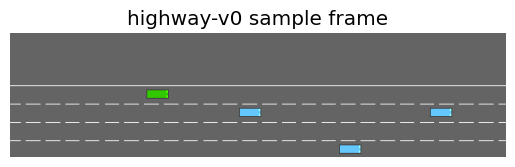

In [13]:
# CELL 10 – TEST ENVIRONMENT RENDERING (Quick Sanity)

print("Visualizing highway-v0 environment...")
env = gym.make('highway-v0', render_mode='rgb_array')
cfg = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10
}
if hasattr(env, "configure"): env.configure(cfg)
else: env.unwrapped.config.update(cfg)

obs, _ = env.reset()
frame = env.render()
print("Frame shape:", None if frame is None else frame.shape)
if frame is not None and np.mean(frame) > 0:
    img_path = os.path.join(path_HW5, 'Videos', 'debug_frame_highway-v0.png')
    imageio.imwrite(img_path, frame)
    plt.imshow(frame); plt.title("highway-v0 sample frame"); plt.axis('off'); plt.show()
env.close()

In [14]:
# ...existing code...
# REPLACEMENT/IMPROVED CELLS (cells after CELL 10: LeaderFollowerMultiAgent, ColorAgentsWrapper, SharedDQNMultiTL, Part 11 driver)
import math
from collections import deque
import torch

def _sigmoid(x: float) -> float:
    return 1.0 / (1.0 + math.exp(-float(x)))

def _unify_obs_dict_simple(obs_any):
    if isinstance(obs_any, dict):
        keys = sorted(obs_any.keys(), key=lambda k: int(k))
        return [np.asarray(obs_any[k]) for k in keys]
    if isinstance(obs_any, (list, tuple)):
        return [np.asarray(x) for x in obs_any]
    if isinstance(obs_any, np.ndarray) and obs_any.ndim >= 1:
        if obs_any.ndim >= 2:
            return [np.asarray(obs_any[i]) for i in range(obs_any.shape[0])]
        return [np.asarray(obs_any)]
    return [np.asarray(obs_any)]


class LeaderFollowerMultiAgent:
    """
    Improved leader-follower multi-agent with:
      - imitation replay (mentor duplicates proportional to similarity)
      - soft sync (tau) from leader -> follower leader_net
      - multiple internal learning updates per step (learning_updates_per_step)
      - robust handling of env signatures and padding
    """
    def __init__(self, env, num_agents=4, leader_idx=0, network_type='linear',
                 device=device, seed=11, scale=1.0, running_window=50, sync_every=10,
                 save_dir=None, imitation_bonus=0.1, max_mentor_copies=3, tau=0.1,
                 learning_updates_per_step=1):
        self.env = env
        self.num_agents = int(num_agents)
        self.leader_idx = int(leader_idx)
        self.network_type = network_type
        self.device = device
        self.seed = seed
        self.scale = float(scale) if float(scale) != 0.0 else 1.0
        self.running_window = int(running_window)
        self.sync_every = int(sync_every)
        self.save_dir = save_dir or os.path.join(path_HW5, "Models", "lf_ma")
        os.makedirs(self.save_dir, exist_ok=True)
        self.imitation_bonus = float(imitation_bonus)
        self.max_mentor_copies = int(max_mentor_copies)
        self.tau = float(tau)
        self.learning_updates_per_step = int(learning_updates_per_step)

        # sample sizes from env
        obs_any, _ = self.env.reset()
        obs_list = _unify_obs_dict_simple(obs_any)
        sample = obs_list[0]
        self.state_size = int(np.prod(sample.shape))
        sp = getattr(self.env, "action_space", None)
        self.action_size = sp.n if hasattr(sp, "n") else int(sp.shape[0])

        # leader agent
        self.leader = Agent(self.state_size, self.action_size, network_type, seed)

        # followers: build list in-order (None at leader_idx, dict at follower positions)
        self.followers = []
        for i in range(self.num_agents):
            if i == self.leader_idx:
                self.followers.append(None)
                continue
            own = Agent(self.state_size, self.action_size, network_type, seed + 100 + i)
            # create leader snapshot module matching leader architecture
            if isinstance(self.leader.qnetwork_local, QNetwork_Linear):
                leader_net = QNetwork_Linear(self.state_size, self.action_size, seed).to(self.device)
            else:
                leader_net = QNetwork_CNN(self.action_size, seed).to(self.device)
            # attempt to copy weights; non-matching keys are ignored
            try:
                leader_net.load_state_dict(self.leader.qnetwork_local.state_dict(), strict=False)
            except Exception:
                try:
                    src = self.leader.qnetwork_local.state_dict()
                    tgt = leader_net.state_dict()
                    for k, v in src.items():
                        if k in tgt and tgt[k].size() == v.size():
                            tgt[k].copy_(v)
                    leader_net.load_state_dict(tgt)
                except Exception:
                    pass
            leader_net.eval()
            self.followers.append({"own": own, "leader_net": leader_net, "rewards": deque(maxlen=self.running_window)})

        # running rewards tracker (leader + followers)
        self.running_rewards = [deque(maxlen=self.running_window) for _ in range(self.num_agents)]
        self.rng = np.random.RandomState(seed)

    def _flat(self, obs):
        return np.asarray(obs, dtype=np.float32).ravel()

    def _running_mean(self, idx):
        arr = list(self.running_rewards[idx])
        return float(np.mean(arr)) if arr else 0.0

    def _soft_update(self, source_net, target_net, tau):
        with torch.no_grad():
            sd_src = source_net.state_dict()
            sd_tgt = target_net.state_dict()
            for k in sd_tgt.keys():
                if k in sd_src and sd_src[k].size() == sd_tgt[k].size():
                    sd_tgt[k].data.copy_(tau * sd_src[k].data + (1.0 - tau) * sd_tgt[k].data)
            target_net.load_state_dict(sd_tgt)

    def _select_actions(self, states_flat, eps):
        actions = [0] * self.num_agents

        # leader action
        s_leader = torch.from_numpy(states_flat[self.leader_idx]).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
            ql = self.leader.qnetwork_local(s_leader).cpu().numpy().squeeze(0)
        if self.rng.rand() < eps:
            actions[self.leader_idx] = int(self.rng.randint(0, self.action_size))
        else:
            actions[self.leader_idx] = int(np.argmax(ql))

        # followers
        for i in range(self.num_agents):
            if i == self.leader_idx:
                continue
            s = torch.from_numpy(states_flat[i]).float().unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_own = self.followers[i]["own"].qnetwork_local(s).cpu().numpy().squeeze(0)
                q_leader = self.followers[i]["leader_net"](s).cpu().numpy().squeeze(0)
            leader_mean = self._running_mean(self.leader_idx)
            own_mean = self._running_mean(i)
            alpha = _sigmoid((leader_mean - own_mean) / float(self.scale))
            alpha = float(np.clip(alpha, 0.0, 1.0))

            # combine Qs but first normalize (stabilize scale differences)
            q_own_norm = (q_own - q_own.mean()) / (q_own.std() + 1e-8)
            q_lead_norm = (q_leader - q_leader.mean()) / (q_leader.std() + 1e-8)
            q_comb = (1.0 - alpha) * q_own_norm + alpha * q_lead_norm

            if self.rng.rand() < eps:
                actions[i] = int(self.rng.randint(0, self.action_size))
            else:
                actions[i] = int(np.argmax(q_comb))
        return actions

    def _sync_followers(self):
        for i in range(self.num_agents):
            if i == self.leader_idx:
                continue
            try:
                # soft update follower leader_net toward current leader weights
                self._soft_update(self.leader.qnetwork_local, self.followers[i]["leader_net"], self.tau)
            except Exception:
                try:
                    self.followers[i]["leader_net"].load_state_dict(self.leader.qnetwork_local.state_dict(), strict=False)
                except Exception:
                    pass

 

def train(self, n_episodes=200, max_steps=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
          save_every=50):
    eps = float(eps_start)
    history = {"leader": [], "followers": {i: [] for i in range(self.num_agents) if i != self.leader_idx}}
    for ep in range(1, n_episodes + 1):
        obs_any, _ = self.env.reset()
        obs_list = _unify_obs_dict_simple(obs_any)
        if len(obs_list) < self.num_agents:
            pad = [np.zeros_like(obs_list[0]) for _ in range(self.num_agents - len(obs_list))]
            obs_list = obs_list + pad
        states = [self._flat(s) for s in obs_list[:self.num_agents]]
        totals = [0.0] * self.num_agents

        for t in range(max_steps):
            actions = self._select_actions(states, eps)
            try:
                action_dict = {i: actions[i] for i in range(self.num_agents)}
                nxt_any = self.env.step(action_dict)
            except Exception:
                nxt_any = self.env.step(actions[0])

            # normalize step output
            if len(nxt_any) == 5:
                obs_next_raw, rewards, terminated, truncated, infos = nxt_any
            elif len(nxt_any) == 4:
                obs_next_raw, rewards, terminated, infos = nxt_any
                truncated = False
            else:
                obs_next_raw, rewards = nxt_any[0], nxt_any[1]
                terminated = truncated = False
                infos = None

            if isinstance(rewards, (list, tuple, np.ndarray, dict)):
                rews_list = self._unify_to_list_local(rewards, self.num_agents)
            else:
                rews_list = [float(rewards)] + [0.0] * (self.num_agents - 1)

            if isinstance(terminated, (list, tuple, np.ndarray, dict)):
                terms = self._unify_to_list_local(terminated, self.num_agents)
            else:
                terms = [bool(terminated or truncated)] * self.num_agents

            nxt_list = _unify_obs_dict_simple(obs_next_raw)
            if len(nxt_list) < self.num_agents:
                pad = [np.zeros_like(nxt_list[0]) for _ in range(self.num_agents - len(nxt_list))]
                nxt_list = nxt_list + pad
            next_states = [self._flat(s) for s in nxt_list[:self.num_agents]]

            for i in range(self.num_agents):
                r = float(rews_list[i])
                d = bool(terms[i])
                totals[i] += r
                self.running_rewards[i].append(r)
                if i == self.leader_idx:
                    try:
                        self.leader.step(states[i], int(actions[i]), r, next_states[i], d)
                    except Exception:
                        pass
                    # leader internal learning updates handled by Agent.step
                else:
                    try:
                        self.followers[i]["own"].step(states[i], int(actions[i]), r, next_states[i], d)
                    except Exception:
                        pass

                    # imitation auxiliary experiences (mentor duplicates proportional to alpha)
                    leader_mean = self._running_mean(self.leader_idx)
                    own_mean = self._running_mean(i)
                    alpha = _sigmoid((leader_mean - own_mean) / float(self.scale))
                    copies = int(round(self.max_mentor_copies * float(alpha)))
                    for _c in range(copies):
                        # add a transition using mentor (leader) action and slight imitation bonus
                        try:
                            self.followers[i]["own"].memory.add(states[i], actions[self.leader_idx],
                                                                 r + (self.imitation_bonus * alpha),
                                                                 next_states[i], d)
                        except Exception:
                            pass

                    # extra learning updates for follower to catch up faster
                    try:
                        for _u in range(self.learning_updates_per_step):
                            if len(self.followers[i]["own"].memory) > BATCH_SIZE:
                                self.followers[i]["own"].learn(self.followers[i]["own"].memory.sample())
                    except Exception:
                        pass

            states = next_states
            if all(terms):
                break

        # Optional periodic soft sync from leader to followers to keep mentor updated
        if ep % self.sync_every == 0:
            self._sync_followers()

        eps = max(eps_end, eps * eps_decay)

        history["leader"].append(totals[self.leader_idx])
        for i in range(self.num_agents):
            if i == self.leader_idx: continue
            history["followers"][i].append(totals[i])

        if ep % save_every == 0 or ep == n_episodes:
            torch.save(self.leader.qnetwork_local.state_dict(), os.path.join(self.save_dir, f'leader_local_ep{ep}.pth'))
            for i in range(self.num_agents):
                if i == self.leader_idx: continue
                torch.save(self.followers[i]["own"].qnetwork_local.state_dict(),
                           os.path.join(self.save_dir, f'f{i}_own_local_ep{ep}.pth'))

        if ep % 10 == 0 or ep == 1:
            follower_means = {i: float(np.mean(history["followers"][i][-10:]) if history["followers"][i] else 0.0) for i in history["followers"]}
            print(f"Ep {ep}/{n_episodes} | leader={history['leader'][-1]:.2f} | follower_last10_means={follower_means} | eps={eps:.3f}")

    return history

def evaluate_and_record(self, outdir, episodes=3, max_steps=1000):
    os.makedirs(outdir, exist_ok=True)
    try:
        from gymnasium.wrappers import RecordVideo
        RV = RecordVideo
    except Exception:
        from gym.wrappers import RecordVideo as RV
    env_wr = RV(self.env, video_folder=outdir, name_prefix="lf_eval", episode_trigger=lambda e: True)
    results = {"leader": [], "followers": {i: [] for i in range(self.num_agents) if i != self.leader_idx}}
    for ep in range(episodes):
        obs_any, _ = env_wr.reset()
        obs_list = _unify_obs_dict_simple(obs_any)
        if len(obs_list) < self.num_agents:
            pad = [np.zeros_like(obs_list[0]) for _ in range(self.num_agents - len(obs_list))]
            obs_list = obs_list + pad
        states = [self._flat(s) for s in obs_list[:self.num_agents]]
        totals = [0.0] * self.num_agents
        done_flags = [False] * self.num_agents

        for t in range(max_steps):
            actions = self._select_actions(states, eps=0.0)
            try:
                nxt_any = env_wr.step({i: actions[i] for i in range(self.num_agents)})
            except Exception:
                nxt_any = env_wr.step(actions[0])

            if len(nxt_any) == 5:
                obs_next_raw, rewards, terminated, truncated, infos = nxt_any
            elif len(nxt_any) == 4:
                obs_next_raw, rewards, terminated, infos = nxt_any
                truncated = False
            else:
                obs_next_raw, rewards = nxt_any[0], nxt_any[1]
                terminated = truncated = False
                infos = None

            rews_list = self._unify_to_list_local(rewards, self.num_agents) if isinstance(rewards, (list, tuple, np.ndarray, dict)) else [float(rewards)] + [0.0] * (self.num_agents - 1)
            terms = self._unify_to_list_local(terminated, self.num_agents) if isinstance(terminated, (list, tuple, np.ndarray, dict)) else [bool(terminated or truncated)] * self.num_agents

            nxt_list = _unify_obs_dict_simple(obs_next_raw)
            if len(nxt_list) < self.num_agents:
                pad = [np.zeros_like(nxt_list[0]) for _ in range(self.num_agents - len(nxt_list))]
                nxt_list = nxt_list + pad
            next_states = [self._flat(s) for s in nxt_list[:self.num_agents]]

            for i in range(self.num_agents):
                totals[i] += float(rews_list[i])
                done_flags[i] = bool(terms[i])

            states = next_states
            if all(done_flags):
                break

        results["leader"].append(totals[self.leader_idx])
        for i in range(self.num_agents):
            if i == self.leader_idx: continue
            results["followers"][i].append(totals[i])
    env_wr.close()
    return results

def _unify_to_list_local(self, x_any, n):
    if isinstance(x_any, dict):
        keys = sorted(x_any.keys(), key=lambda k: int(k))
        return [x_any[k] for k in keys][:n]
    if isinstance(x_any, (list, tuple, np.ndarray)):
        return list(x_any)[:n]
    return [x_any] * n

# -------------------------------------------------------------------------
# Color wrapper (keep safe, idempotent)
try:
    from gymnasium import Wrapper as GymWrapper
except Exception:
    try:
        from gym import Wrapper as GymWrapper
    except Exception:
        GymWrapper = object  # fallback

def _rgb(color):
    try:
        mx = max(color)
    except Exception:
        return (255, 0, 255)
    if mx <= 1.0:
        return tuple(int(round(c * 255)) for c in color)
    return tuple(int(c) for c in color)

class ColorAgentsWrapper(GymWrapper):
    """
    Robust ColorAgentsWrapper:
     - Tries multiple places to find vehicle objects (controlled_vehicles, road.vehicles, world.vehicles)
     - Applies distinct colors to each agent and attempts several common attribute names
     - Safe (silently ignores failures)
    """
    def __init__(self, env, agent_colors):
        super().__init__(env)
        # Normalize colors to 0..255 ints
        def _norm(c):
            try:
                mx = max(c)
            except Exception:
                return (255, 0, 255)
            if mx <= 1.0:
                return tuple(int(round(x * 255)) for x in c)
            return tuple(int(x) for x in c)
        self.agent_colors = [_norm(c) for c in agent_colors]

        def _find_vehicle_list(self):
        # Try common locations used by highway-env versions
            candidates = []
            try:
                cand = getattr(self.env.unwrapped, "controlled_vehicles", None)
                if cand:
                    candidates.append(cand)
            except Exception:
                pass
            try:
                road = getattr(self.env.unwrapped, "road", None)
                if road is not None:
                    v = getattr(road, "vehicles", None)
                    if v:
                        candidates.append(v)
                    # some versions keep actors
                    a = getattr(road, "actors", None)
                    if a:
                        candidates.append(a)
            except Exception:
                pass
            try:
                world = getattr(self.env.unwrapped, "world", None)
                if world is not None:
                    v = getattr(world, "vehicles", None)
                    if v:
                        candidates.append(v)
            except Exception:
                pass
            # Flatten candidate lists and return first meaningful sequence
            for seq in candidates:
                try:
                    # convert to list-like
                    if isinstance(seq, dict):
                        seq_list = list(seq.values())
                    else:
                        seq_list = list(seq)
                    if seq_list:
                        return seq_list
                except Exception:
                    continue
            return []

    def _apply_colors(self):
        vehicles = self._find_vehicle_list()
        if not vehicles:
            return
        for i, v in enumerate(vehicles):
            color = self.agent_colors[i % len(self.agent_colors)]
            try:
                # Try several common attribute names & setter methods
                if hasattr(v, "set_color"):
                    try:
                        v.set_color(color)
                        continue
                    except Exception:
                        pass
                # common attribute names in various versions
                for attr in ("color", "colour", "color_rgb", "COLOR", "fill_color"):
                    try:
                        setattr(v, attr, color)
                    except Exception:
                        pass
                # some vehicle renderers read `c` or `draw_color`
                for attr in ("c", "draw_color", "_draw_color"):
                    try:
                        setattr(v, attr, color)
                    except Exception:
                        pass
            except Exception:
                pass

    def reset(self, *args, **kwargs):
        out = super().reset(*args, **kwargs)
        try:
            self._apply_colors()
        except Exception:
            pass
        return out

    def step(self, action):
        out = super().step(action)
        try:
            self._apply_colors()
        except Exception:
            pass
        return out


    def step(self, action):
        out = super().step(action)
        try:
            self._apply_colors()
        except Exception:
            pass
        return out

AGENT_COLORS = [
    (255, 0, 0),      # red
    (0, 120, 255),    # blue
    (0, 200, 0),      # green
    (255, 215, 0),    # gold
    (160, 32, 240),   # purple
    (255, 20, 147),   # pink
]

# -------------------------------------------------------------------------
# SharedDQNMultiTL (improved)
from typing import Any, Dict, List, Tuple, Optional
from pathlib import Path

class SharedDQNMultiTL:
    """
    Improved SharedDQNMultiTL:
      - mentor-weighted duplicates (as before) + imitation bonus
      - extra internal learning updates per env step (learning_updates)
      - safer checkpoint loading that accepts dicts with common keys
      - double-checks action_space types for Dict vs single-space envs
    """
    def __init__(self, env, network_type: str, device: torch.device, seed: int = 11,
                 similarity_metric: str = "cosine", high_sim_threshold: float = 0.85,
                 mid_sim_threshold: float = 0.55, simplified_mode: bool = False,
                 mentor_bias_scale: float = 2.0, max_mentor_copies: int = 2, imitation_bonus: float = 0.1,
                 use_stacked_obs: bool = True, learning_updates_per_step: int = 1):
        self.env = env
        self.device = device
        self.network_type = network_type
        self.rng = np.random.RandomState(seed)
        self.similarity_metric = similarity_metric
        self.high_sim_threshold = float(high_sim_threshold)
        self.mid_sim_threshold = float(mid_sim_threshold)
        self.mentor_bias_scale = float(mentor_bias_scale)
        self.max_mentor_copies = int(max_mentor_copies)
        self.imitation_bonus = float(imitation_bonus)
        self.simplified_mode = bool(simplified_mode)
        self.use_stacked_obs = bool(use_stacked_obs)
        self.learning_updates_per_step = int(learning_updates_per_step)

            # infer agents and sizes
        obs_any, _ = self.env.reset()
        obs_dict = self._unify_obs_dict(obs_any)
        self.num_agents = max(1, len(obs_dict))
        sample_obs = np.asarray(next(iter(obs_dict.values())))
        base_state_size = int(np.prod(sample_obs.shape))
        self.state_size = base_state_size * (2 if self.use_stacked_obs else 1)

        sp = getattr(self.env, "action_space", None)
        if hasattr(sp, "spaces"):  # Dict action space
            self.action_size = next(iter(sp.spaces.values())).n
        else:
            self.action_size = sp.n

        # shared agent
        self.agent = Agent(self.state_size, self.action_size, network_type, seed)

    def _unify_obs_dict(self, obs_any):
        """Normalize env observations -> dict[int, np.ndarray]. Robust to dict/list/ndarray/scalars."""
        try:
            if isinstance(obs_any, dict):
                # prefer int keys if possible, otherwise stable string ordering
                try:
                    return {int(k): np.asarray(v) for k, v in obs_any.items()}
                except Exception:
                    keys = sorted(obs_any.keys(), key=lambda k: str(k))
                    return {i: np.asarray(obs_any[k]) for i, k in enumerate(keys)}
            if isinstance(obs_any, (list, tuple)):
                return {i: np.asarray(obs_any[i]) for i in range(len(obs_any))}
            if isinstance(obs_any, np.ndarray):
                if obs_any.ndim >= 2:
                    return {i: np.asarray(obs_any[i]) for i in range(obs_any.shape[0])}
                return {0: np.asarray(obs_any)}
            # scalar or unknown
            return {0: np.asarray(obs_any)}
        except Exception:
            # last-resort: wrap as single observation
            return {0: np.asarray(obs_any)}
        # ...existing code... 
    @staticmethod
    def _unify_to_list(x_any: Any, n: int) -> List[Any]:
            """
            Robust conversion of various env return formats into a list of length n.
            - Accepts dicts with int keys, string keys, non-sequential keys.
            - Accepts lists/tuples/ndarrays and scalars.
            - Accepts None -> returns [None]*n.
            - Pads with None if shorter, truncates if longer.
            """
            if x_any is None:
                return [None] * n

            # dict: try to interpret keys as integers first (preferred)
            if isinstance(x_any, dict):
                try:
                    # map integer keys (works if keys are '0','1' or 0,1,...)
                    int_map = {int(k): v for k, v in x_any.items()}
                    return [int_map.get(i, None) for i in range(n)]
                except Exception:
                    # fallback: deterministic ordering by key string (stable)
                    keys = sorted(x_any.keys(), key=lambda k: str(k))
                    vals = [x_any[k] for k in keys]
                    if len(vals) >= n:
                        return vals[:n]
                    return vals + [None] * (n - len(vals))

            # list/tuple/numpy
            if isinstance(x_any, (list, tuple)):
                vals = list(x_any)[:n]
                if len(vals) < n:
                    vals += [None] * (n - len(vals))
                return vals

            if isinstance(x_any, np.ndarray):
                # convert 0-d to repeated scalar, otherwise to list
                if x_any.ndim == 0:
                    return [x_any.item()] * n
                vals = list(x_any.tolist())[:n]
                if len(vals) < n:
                    vals += [None] * (n - len(vals))
                return vals

            # scalar: replicate to length n
            return [x_any] * n 

    @staticmethod
    def _flatten(x: np.ndarray) -> np.ndarray:
            return np.asarray(x, dtype=np.float32).ravel()

    def _stack_obs(self, cur_obs: np.ndarray, prev_obs: Optional[np.ndarray]) -> np.ndarray:
            if not self.use_stacked_obs:
                return self._flatten(cur_obs)
            if prev_obs is None:
                zeros = np.zeros_like(cur_obs, dtype=np.float32)
                return np.concatenate([self._flatten(cur_obs), self._flatten(zeros)], axis=0)
            return np.concatenate([self._flatten(cur_obs), self._flatten(prev_obs)], axis=0)

    def _similarity_coef(self, a: np.ndarray, b: np.ndarray) -> float:
            a_f = self._flatten(a)
            b_f = self._flatten(b)
            if self.similarity_metric == "euclidean":
                denom = np.linalg.norm(a_f) + np.linalg.norm(b_f) + 1e-8
                dist = np.linalg.norm(a_f - b_f) / denom
                sim = 1.0 - float(np.clip(dist, 0.0, 1.0))
            else:
                denom = (np.linalg.norm(a_f) * np.linalg.norm(b_f)) + 1e-8
                cos = float(np.dot(a_f, b_f) / denom)
                sim = (cos + 1.0) * 0.5
            return float(np.clip(sim, 0.0, 1.0))    

    def _safe_gap_reward_from_obs(self, obs: np.ndarray) -> float:
            try:
                presence = obs[:, 0]
                x = obs[:, 1]
                y = obs[:, 2]
            except Exception:
                return 0.0
            same_lane_ahead = (presence > 0.5) & (x > 0) & (np.abs(y) < 0.2)
            if not np.any(same_lane_ahead):
                return 0.0
            min_x_ahead = float(np.min(x[same_lane_ahead]))
            if min_x_ahead < 0.1:
                return -0.5
            if 0.2 <= min_x_ahead <= 0.6:
                return 0.25
            return 0.0    

    def _speed_align_bonus_from_obs(self, cur_obs: np.ndarray, prev_obs: Optional[np.ndarray]) -> float:
            return 0.0  # keep low complexity here; can be re-enabled if needed

    def _opposite_action(self, a: int) -> int:
            if self.action_size >= 5:
                mapping = {0: 2, 2: 0, 3: 4, 4: 3}
                return mapping.get(a, a)
            choices = [x for x in range(self.action_size) if x != a]
            return int(self.rng.choice(choices)) if choices else a        

    def _act_batch_v2v(self, obs_list: List[np.ndarray], eps: float) -> Tuple[List[int], List[float], List[int]]:
            states_in: List[np.ndarray] = []
            for i in range(len(obs_list)):
                prev_obs = obs_list[i - 1] if i > 0 else None
                states_in.append(self._stack_obs(obs_list[i], prev_obs))
            st = torch.from_numpy(np.stack(states_in, axis=0)).float().to(self.device)

            self.agent.qnetwork_local.eval()
            with torch.no_grad():
                q_all = self.agent.qnetwork_local(st)
            self.agent.qnetwork_local.train()

            actions: List[int] = [0] * len(obs_list)
            coefs: List[float] = [0.0] * len(obs_list)
            mentor_actions: List[int] = [0] * len(obs_list)

            q0 = q_all[0].cpu().numpy()
            if self.rng.rand() < eps:
                actions[0] = int(self.rng.randint(0, self.action_size))
            else:
                actions[0] = int(np.argmax(q0))

            for i in range(1, len(obs_list)):
                mentor_actions[i] = actions[i - 1]
                coef = self._similarity_coef(obs_list[i], obs_list[i - 1])
                coefs[i] = coef

                qi = q_all[i].clone()
                qi[mentor_actions[i]] = qi[mentor_actions[i]] + (self.mentor_bias_scale * coef)
                qi_np = qi.cpu().numpy()

                if self.rng.rand() < eps:
                    actions[i] = int(self.rng.randint(0, self.action_size))
                    continue

                if self.simplified_mode:
                    if coef >= self.high_sim_threshold:
                        actions[i] = int(mentor_actions[i])
                    else:
                        actions[i] = int(np.argmax(qi_np))
                else:
                    if coef >= self.high_sim_threshold:
                        actions[i] = int(mentor_actions[i]) if (self.rng.rand() < 0.85) else int(np.argmax(qi_np))
                    elif coef >= self.mid_sim_threshold:
                        actions[i] = int(mentor_actions[i]) if (self.rng.rand() < 0.6) else int(np.argmax(qi_np))
                    else:
                        if self.rng.rand() < 0.5:
                            actions[i] = int(self._opposite_action(mentor_actions[i]))
                        else:
                            actions[i] = int(np.argmax(qi_np))
            return actions, coefs, mentor_actions    

    def load_transfer_weights(self, checkpoint_path: str) -> None:
            try:
                sd = torch.load(checkpoint_path, map_location=self.device)
                # Accept common keys in saved dicts
                if isinstance(sd, dict):
                    for key in ('qnetwork_local_state_dict', 'model_state_dict', 'state_dict', 'qnetwork_state_dict'):
                        if key in sd:
                            sd = sd[key]
                            break
                missing_unexp = self.agent.qnetwork_local.load_state_dict(sd, strict=False)
                print("Transfer load done (strict=False). Missing/unexpected:", missing_unexp)
            except Exception as e:
                print("⚠ Warning: Size mismatch or failed load:", e)
                print("  Continuing with randomly initialized shared agent.")    

    def train(self, runs: List[int], episodes_per_run: int, max_steps: int,
                out_models: str, out_data: str, save_every: int = 100,
                eps_start: float = 1.0, eps_end: float = 0.01, eps_decay: float = 0.995) -> pd.DataFrame:
            os.makedirs(out_models, exist_ok=True)
            os.makedirs(out_data, exist_ok=True)
            df = pd.DataFrame()
            for r in runs:
                eps = float(eps_start)
                rewards_agents: List[List[float]] = [[] for _ in range(self.num_agents)]
                for ep in trange(1, episodes_per_run + 1, desc=f"MA-TL Run {r}"):
                    obs_any, _ = self.env.reset()
                    obs_dict = self._unify_obs_dict(obs_any)
                    done = {i: False for i in range(self.num_agents)}
                    totals = [0.0] * self.num_agents
                    for _ in range(max_steps):
                        obs_list = [obs_dict[i] for i in range(self.num_agents)]
                        actions, coefs, mentor_actions = self._act_batch_v2v(obs_list, eps)
                        action_dict = {i: actions[i] for i in range(self.num_agents)}
                        try:
                            nxt, rews, terms, truncs, infos = self.env.step(action_dict)
                        except Exception:
                            nxt, rews, terms, truncs, infos = self.env.step(actions[0])
                        nxt_dict = self._unify_obs_dict(nxt)
                        rews_l = self._unify_to_list(rews, self.num_agents)
                        terms_l = self._unify_to_list(terms, self.num_agents)
                        truncs_l = self._unify_to_list(truncs, self.num_agents)
                        next_states_in: List[np.ndarray] = []
                        for i in range(self.num_agents):
                            prev_next = nxt_dict[i - 1] if i > 0 else None
                            next_states_in.append(self._stack_obs(nxt_dict[i], prev_next))

                        # replay + shaping + mentor copies
                        for i in range(self.num_agents):
                            d = bool(terms_l[i] or truncs_l[i])
                            shaped_reward = float(rews_l[i])
                            shaped_reward += self._safe_gap_reward_from_obs(obs_list[i])
                            shaped_reward += self._speed_align_bonus_from_obs(obs_list[i], obs_list[i - 1] if i > 0 else None)
                            prev_obs_for_stack = obs_list[i - 1] if i > 0 else None
                            state_in = self._stack_obs(obs_list[i], prev_obs_for_stack)
                            # primary
                            self.agent.step(state_in, actions[i], shaped_reward, next_states_in[i], d)
                            # mentor-weighted duplicates
                            if i > 0 and self.max_mentor_copies > 0:
                                copies = int(np.round(self.max_mentor_copies * float(coefs[i])))
                                for _copy in range(copies):
                                    self.agent.memory.add(state_in, mentor_actions[i],
                                                        shaped_reward + (self.imitation_bonus * float(coefs[i])),
                                                        next_states_in[i], d)
                            totals[i] += shaped_reward
                            done[i] = d

                        obs_dict = nxt_dict

                        # extra learning updates for shared agent
                        try:
                            for _u in range(self.learning_updates_per_step):
                                if len(self.agent.memory) > BATCH_SIZE:
                                    self.agent.learn(self.agent.memory.sample())
                        except Exception:
                            pass

                        if all(done.values()):
                            break

                    for i in range(self.num_agents):
                        rewards_agents[i].append(totals[i])
                    eps = max(float(eps_end), float(eps * eps_decay))
                    if ep % save_every == 0:
                        rd = Path(out_models) / f"Models_Run_{r}"
                        rd.mkdir(parents=True, exist_ok=True)
                        torch.save(self.agent.qnetwork_local.state_dict(), rd / f"ma_shared_local_{ep}.pth")
                        torch.save(self.agent.qnetwork_target.state_dict(), rd / f"ma_shared_target_{ep}.pth")

                # Save run rewards (per-agent columns)
                for i in range(self.num_agents):
                    df[f"Run_{r}_Agent_{i}"] = rewards_agents[i]
                df.to_csv(os.path.join(out_data, f"Episodes_reward_run_{r}.csv"), index=False)
            return df    

    def evaluate_and_record(self, video_dir: str, episodes: int = 3) -> Tuple[List[float], List[float]]:
            os.makedirs(video_dir, exist_ok=True)
            try:
                from gymnasium.wrappers import RecordVideo
                RV = RecordVideo
            except Exception:
                from gym.wrappers import RecordVideo as RV
            env_wrapped = RV(self.env, video_folder=video_dir, name_prefix="ma_tl_eval", episode_trigger=lambda e: True)
            totals = [0.0] * self.num_agents
            crashes = [0] * self.num_agents
            for _ in range(episodes):
                obs_any, _ = env_wrapped.reset()
                obs_dict = self._unify_obs_dict(obs_any)
                done = {i: False for i in range(self.num_agents)}
                while not all(done.values()):
                    obs_list = [obs_dict[i] for i in range(self.num_agents)]
                    actions, _, _ = self._act_batch_v2v(obs_list, eps=0.0)
                    action_dict = {i: actions[i] for i in range(self.num_agents)}
                    try:
                        nxt, rews, terms, truncs, infos = env_wrapped.step(action_dict)
                    except Exception:
                        nxt, rews, terms, truncs, infos = env_wrapped.step(actions[0])
                    nxt_dict = self._unify_obs_dict(nxt)
                    rews_l = self._unify_to_list(rews, self.num_agents)
                    terms_l = self._unify_to_list(terms, self.num_agents)
                    truncs_l = self._unify_to_list(truncs, self.num_agents)
                    infos_l = self._unify_to_list(infos, self.num_agents)
                    for i in range(self.num_agents):
                        totals[i] += float(rews_l[i])
                        info_i = infos_l[i] if isinstance(infos_l[i], dict) else {}
                        if isinstance(info_i, dict) and info_i.get("crashed", False):
                            crashes[i] += 1
                        done[i] = bool(terms_l[i] or truncs_l[i])
                    obs_dict = nxt_dict
            env_wrapped.close()
            avg = [t / max(1, episodes) for t in totals]
            crash_rate = [c / max(1, episodes) for c in crashes]
            return avg, crash_rate                   

       
# -------------------------------------------------------------------------
# Part 11 – Multi-agent transfer learning with unique colors (driver)
video_dir_ma = os.path.join(path_HW5, "Videos")
models_ma    = os.path.join(path_HW5, "Models", "ma_tl")
data_ma      = os.path.join(path_HW5, "Data_Average_Reward", "ma_tl")
os.makedirs(models_ma, exist_ok=True)
os.makedirs(data_ma, exist_ok=True)

# Build env with 4 agents and colorize them
env = gym.make("highway-v0", render_mode="rgb_array")
cfg = {
    "controlled_vehicles": 4,
    "policy_frequency": 5,
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 7,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    }
}
if hasattr(env, "configure"): env.configure(cfg)
else: env.unwrapped.config.update(cfg)
env.reset()

env = ColorAgentsWrapper(env, AGENT_COLORS[:cfg["controlled_vehicles"]])
obs_any, _ = env.reset()
print("MA obs format type:", type(obs_any))

# Initialize coach and load transfer weights from a single-agent fast policy
coach = SharedDQNMultiTL(env, network_type="linear", device=device,
                         mentor_bias_scale=2.0, max_mentor_copies=2, imitation_bonus=0.15,
                         use_stacked_obs=True, learning_updates_per_step=2)

# Prefer fast-highway single-agent checkpoint; fallback to merge
fast_ckpt = os.path.join(path_HW5, 'Models', '2_Models_fastHighway', 'Models_Run_1', 'checkpoint_dqn_state_highway-fast-v0_local_200.pth')
merge_ckpt= os.path.join(path_HW5, 'Models', '1_Models_merge',       'Models_Run_1', 'checkpoint_dqn_state_merge-v0_local_200.pth')
src_ckpt = fast_ckpt if os.path.exists(fast_ckpt) else merge_ckpt
print("Transfer source:", src_ckpt, "exists:", os.path.exists(src_ckpt))
if os.path.exists(src_ckpt):
    coach.load_transfer_weights(src_ckpt)
else:
    print("Warning: no source checkpoint found. Training will start from scratch.")

# Train (increase episodes for stronger final models)
ma_episodes = 120
ma_max_steps = 1000
df_ma_tl = coach.train(
    runs=[1],
    episodes_per_run=ma_episodes,
    max_steps=ma_max_steps,
    out_models=models_ma,
    out_data=data_ma,
    save_every=50,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995,
)
display(df_ma_tl.head())

# Evaluate and record video
avg_ma, crash_ma = coach.evaluate_and_record(video_dir=video_dir_ma, episodes=2)
print("MA-TL avg rewards per agent:", [f"{x:.2f}" for x in avg_ma])
print("MA-TL crash rates per agent:", [f"{x:.2%}" for x in crash_ma])

# Show latest MA video
show_and_plot().show_video(video_dir_ma, "ma_tl_eval")
# ...existing code...
# CELL 11 — REPLACEMENT: robust Multi-Agent Transfer (safe setup, optional train/eval, colored agents)
# ...existing code...
import os, sys, subprocess, time
from pathlib import Path
from PIL import Image
import imageio
# ensure ffmpeg backend for imageio (quiet install if missing)
try:
    import imageio_ffmpeg  # noqa
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "imageio-ffmpeg"])
    import imageio_ffmpeg  # noqa

# Paths
video_dir_ma = os.path.join(path_HW5, "Videos")
models_ma    = os.path.join(path_HW5, "Models", "ma_tl")
data_ma      = os.path.join(path_HW5, "Data_Average_Reward", "ma_tl")
os.makedirs(video_dir_ma, exist_ok=True)
os.makedirs(models_ma, exist_ok=True)
os.makedirs(data_ma, exist_ok=True)

# Configuration for multi-agent highway env
env_name = "highway-v0"
ma_cfg = {
    "controlled_vehicles": 4,
    "policy_frequency": 5,
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 7,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    }
}

# Build base env (try render_mode; fallback if not supported)
try:
    base_env = gym.make(env_name, render_mode="rgb_array")
except Exception:
    base_env = gym.make(env_name)

# Apply configuration in the safest way available
if hasattr(base_env, "configure"):
    try:
        base_env.configure(ma_cfg)
    except Exception:
        # Some highway-env versions expect dict under .config
        try:
            base_env.config.update(ma_cfg)
        except Exception:
            pass
else:
    try:
        base_env.unwrapped.config.update(ma_cfg)
    except Exception:
        pass

# Wrap with ColorAgentsWrapper BEFORE the first reset so it can locate vehicles reliably
env = ColorAgentsWrapper(base_env, AGENT_COLORS[: int(ma_cfg["controlled_vehicles"]) ])

# Reset env safely (support gym / gymnasium signatures)
try:
    res = env.reset()
    # gymnasium returns (obs, info)
    if isinstance(res, tuple) and len(res) >= 1:
        obs_any = res[0]
    else:
        obs_any = res
except Exception:
    obs_any = None

print("Wrapped MA env ready. Sample obs type:", type(obs_any))

# Instantiate multi-agent coach (SharedDQNMultiTL defined earlier)
coach = SharedDQNMultiTL(env, network_type="linear", device=device,
                         mentor_bias_scale=2.0, max_mentor_copies=2,
                         imitation_bonus=0.15, use_stacked_obs=True, learning_updates_per_step=2)

# Try to load a single-agent transfer checkpoint (fast highway preferred, fallback to merge)
fast_ckpt = os.path.join(path_HW5, 'Models', '2_Models_fastHighway', 'Models_Run_1',
                         'checkpoint_dqn_state_highway-fast-v0_local_200.pth')
merge_ckpt = os.path.join(path_HW5, 'Models', '1_Models_merge', 'Models_Run_1',
                         'checkpoint_dqn_state_merge-v0_local_200.pth')
src_ckpt = fast_ckpt if os.path.exists(fast_ckpt) else (merge_ckpt if os.path.exists(merge_ckpt) else None)
print("Transfer candidate:", src_ckpt, "exists:", bool(src_ckpt))

if src_ckpt:
    try:
        coach.load_transfer_weights(src_ckpt)
    except Exception as e:
        print("Transfer load failed:", e)
        print("Continuing from scratch.")

# CONTROL FLAGS — change to True to run long training; False to only run evaluation
RUN_TRAIN = False   # set True to train MA model in this cell (may be long)
RUN_EVAL  = True    # run deterministic evaluation + record videos

# Training (optional)
if RUN_TRAIN:
    ma_episodes = 120        # increase for final experiments
    ma_max_steps = 1000
    print("Starting MA training — episodes:", ma_episodes)
    t0 = time.time()
    try:
        df_ma_tl = coach.train(
            runs=[1],
            episodes_per_run=ma_episodes,
            max_steps=ma_max_steps,
            out_models=models_ma,
            out_data=data_ma,
            save_every=50,
            eps_start=1.0, eps_end=0.05, eps_decay=0.995,
        )
        display(df_ma_tl.head())
    except Exception as e:
        print("Training failed or interrupted:", e)
    print("MA training elapsed (s):", time.time() - t0)

# Evaluation + record (safe)
if RUN_EVAL:
    try:
        avg_ma, crash_ma = coach.evaluate_and_record(video_dir=video_dir_ma, episodes=2)
        print("MA-TL avg rewards per agent:", [f"{x:.2f}" for x in avg_ma])
        print("MA-TL crash rates per agent:", [f"{x:.2%}" for x in crash_ma])
    except Exception as e:
        print("Evaluation failed:", e)

    # display latest MA evaluation video (helper show_and_plot from earlier cells)
    try:
        show_and_plot().show_video(video_dir_ma, "ma_tl_eval")
    except Exception as e:
        print("Could not show video in-notebook:", e)

# Cleanup try
try:
    env.close()
except Exception:
    pass
# ...existing code...

MA obs format type: <class 'numpy.ndarray'>
Transfer source: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\2_Models_fastHighway\Models_Run_1\checkpoint_dqn_state_highway-fast-v0_local_200.pth exists: True
⚠ Warning: Size mismatch or failed load: Error(s) in loading state_dict for QNetwork_Linear:
	size mismatch for net.0.weight: copying a param with shape torch.Size([125, 25]) from checkpoint, the shape in current model is torch.Size([125, 10]).
  Continuing with randomly initialized shared agent.


MA-TL Run 1: 100%|██████████| 120/120 [04:31<00:00,  2.26s/it]


,Run_1_Agent_0,Run_1_Agent_1,Run_1_Agent_2,Run_1_Agent_3,Run_1_Agent_4,Run_1_Agent_5,Run_1_Agent_6
0,22.842965,22.842965,22.842965,22.842965,22.842965,22.842965,22.842965
1,47.309684,47.309684,47.309684,47.309684,47.309684,47.309684,47.309684
2,13.683459,13.683459,13.683459,13.683459,13.683459,13.683459,13.683459
3,30.781328,30.781328,30.781328,30.781328,30.781328,30.781328,30.781328
4,13.526772,13.526772,13.526772,13.526772,13.526772,13.526772,13.526772


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-0.mp4


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-1.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-1.mp4
MA-TL avg rewards per agent: ['19.38', '19.38', '19.38', '19.38', '19.38', '19.38', '19.38']
MA-TL crash rates per agent: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-1.mp4


Wrapped MA env ready. Sample obs type: <class 'numpy.ndarray'>
Transfer candidate: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\2_Models_fastHighway\Models_Run_1\checkpoint_dqn_state_highway-fast-v0_local_200.pth exists: True
⚠ Warning: Size mismatch or failed load: Error(s) in loading state_dict for QNetwork_Linear:
	size mismatch for net.0.weight: copying a param with shape torch.Size([125, 25]) from checkpoint, the shape in current model is torch.Size([125, 10]).
  Continuing with randomly initialized shared agent.
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tas

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-0.mp4


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-1.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-1.mp4
MA-TL avg rewards per agent: ['50.56', '50.56', '50.56', '50.56', '50.56', '50.56', '50.56']
MA-TL crash rates per agent: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\ma_tl_eval-episode-1.mp4


[Merge-v0] obs shape: (5, 5), action size: 5
Training Merge-v0...
Training agent with state for merge-v0...


Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


Iter 1 Episodes:   2%|▎         | 5/200 [00:03<02:03,  1.57it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


Iter 1 Episodes:   8%|▊         | 16/200 [00:10<02:09,  1.42it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


Iter 1 Episodes:  60%|██████    | 121/200 [04:31<04:16,  3.24s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove


Iter 1 Episodes:  67%|██████▋   | 134/200 [05:15<04:44,  4.32s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


Iter 1 Episodes:  91%|█████████ | 182/200 [08:09<01:03,  3.50s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

Iterations: 100%|██████████| 1/1 [09:21<00:00, 561.29s/it]


Training completed in 9.36 min
Total episodes: 200
Reward mean (all): 112.34, std: 35.54, min: 57.92, max: 205.80, median: 106.95
Reward mean (last 50): 119.82


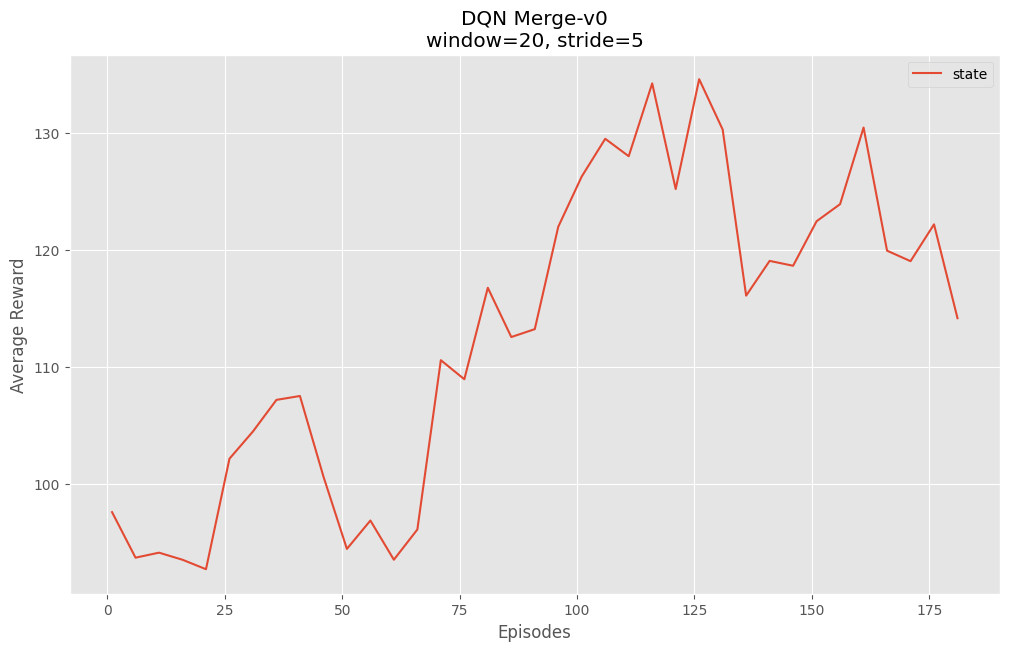

In [42]:
# CELL 11 – TRAIN MERGE-V0 (STATE) — RUN ONCE (skip for daily use)

video_path = os.path.join(path_HW5, 'Videos')
model_path = os.path.join(path_HW5, 'Models/1_Models_merge')
data_path_1 = os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge')
env_name = 'merge-v0'

# Build and configure env
env = gym.make(env_name, render_mode='rgb_array')
cfg = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10,
    "collision_reward": -10.0,
    "high_speed_reward": 1.0,
    "reward_speed_range": [20, 30]
}
if hasattr(env, "configure"): env.configure(cfg)
else: env.unwrapped.config.update(cfg)

obs0, _ = env.reset()
print(f"[Merge-v0] obs shape: {obs0.shape}, action size: {env.action_space.n}")

# Trainer
dqn_merge = DQN(env, env_name, model_path, data_path_1, 'linear')

# Train (RUN ONCE; increase episodes for stronger results)
episodes = 200
max_step = 1500
print("Training Merge-v0...")
t0 = time.time()
df_reward_merge = dqn_merge.train_with_state(n_iteration=[1], n_training_episodes=episodes, max_step=max_step)
t1 = time.time()
print(f"Training completed in {(t1 - t0)/60:.2f} min")

# Save and show training stats
try:
    df_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_1.xlsx'))
    rewards = df_merge['Run_1'].dropna().to_numpy().tolist()
    print(f"Total episodes: {len(rewards)}")
    print(f"Reward mean (all): {mean(rewards):.2f}, std: {np.std(rewards):.2f}, min: {np.min(rewards):.2f}, max: {np.max(rewards):.2f}, median: {median(rewards):.2f}")
    last_n = min(50, len(rewards))
    print(f"Reward mean (last {last_n}): {mean(rewards[-last_n:]):.2f}")
except Exception as e:
    print("Training metrics read failed:", e)

# Plot training curve (rolling mean with CI)
try:
    df_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_1.xlsx'))
    ep_merge = df_merge.T.to_numpy()
    fig, ax = plt.subplots(figsize=(12, 7))
    ax = show_and_plot().plot_training_result(ep_merge, ax, 'DQN Merge-v0', 'state', window=20, stride=5)
    plt.legend(); plt.show()
    fig.savefig(os.path.join(path_HW5, 'Images/1-Merge-task-state.png'), dpi=300)
except Exception as e:
    print("Plotting failed:", e)

In [43]:
# CELL 12 – Load & Evaluate Merge-v0 (state)
# Loads a trained state-based merge-v0 checkpoint, evaluates deterministic episodes,
# records videos to path_HW5/Videos and displays the latest video.


# NOTE: `device` and `path_HW5` are defined earlier in the notebook (CELL 2).
# If not, uncomment and set them here:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# path_HW5 = '...'

def _unpack_reset(res):
    # gym returns obs or (obs, info)
    if isinstance(res, tuple) and len(res) >= 1:
        return res[0]
    return res

def _unpack_step(res):
    # gym (old) -> (obs, reward, done, info)
    # gymnasium -> (obs, reward, terminated, truncated, info)
    if len(res) == 4:
        obs, reward, done, info = res
        return obs, reward, done, info
    elif len(res) == 5:
        obs, reward, terminated, truncated, info = res
        done = bool(terminated or truncated)
        return obs, reward, done, info
    else:
        raise RuntimeError("Unexpected env.step() return signature")

def find_checkpoint(model_dir, requested_episode=None):
    pths = sorted(glob.glob(os.path.join(model_dir, '*.pth')))
    if not pths:
        raise FileNotFoundError(f'No .pth checkpoints found in {model_dir}')
    if requested_episode is not None:
        ep_str = str(requested_episode)
        for p in reversed(pths):
            name = os.path.basename(p)
            if f'_ep{ep_str}' in name or f'ep{ep_str}' in name or f'_episode{ep_str}' in name:
                return p
        print(f'Warning: requested episode {requested_episode} not found; falling back to latest checkpoint.')
    return max(pths, key=os.path.getmtime)

# Paths
merge_model_dir = os.path.join(path_HW5, 'Models', '1_Models_merge', 'Models_Run_1')
videos_dir = os.path.join(path_HW5, 'Videos')
os.makedirs(videos_dir, exist_ok=True)

# Choose checkpoint; set requested_episode to integer if desired
requested_episode = None
ckpt_path = find_checkpoint(merge_model_dir, requested_episode=requested_episode)
print('Using checkpoint:', ckpt_path)

# Build env (no render_mode required for state-based evaluation)
env_name = 'merge-v0'
env = gym.make(env_name)

# Instantiate or reuse Agent (signature: Agent(state_size, action_size, network_type, seed))
try:
    agent  # reuse if present in namespace
    print('Re-using existing `agent` instance.')
except NameError:
    obs_sample = _unpack_reset(env.reset())
    # state_size must be an int for QNetwork_Linear
    state_size = int(np.prod(getattr(obs_sample, 'shape', (obs_sample.size if hasattr(obs_sample,'size') else 1))))
    action_size = env.action_space.n if hasattr(env.action_space, 'n') else env.action_space.shape[0]
    agent = Agent(state_size, action_size, 'linear', seed=11)
    print('Instantiated Agent for evaluation (state-based).')

# Load checkpoint robustly
ckpt = torch.load(ckpt_path, map_location=device)
loaded = False

# Agent does not provide .load(); instead load state_dicts into qnetwork_local
if isinstance(ckpt, dict):
    state_dict = None
    for key in ('qnetwork_local_state_dict', 'model_state_dict', 'state_dict'):
        if key in ckpt:
            state_dict = ckpt[key]
            break
    if state_dict is None and any(isinstance(v, torch.Tensor) for v in ckpt.values()):
        state_dict = ckpt
else:
    state_dict = ckpt

if state_dict is not None:
    try:
        agent.qnetwork_local.load_state_dict(state_dict)
        if hasattr(agent, 'qnetwork_target'):
            try:
                agent.qnetwork_target.load_state_dict(state_dict)
            except Exception:
                pass
        loaded = True
        print('Loaded checkpoint into agent.qnetwork_local (and target if compatible).')
    except Exception as e:
        print('Failed to load state_dict into agent networks:', e)

if not loaded:
    print('Warning: checkpoint was not loaded automatically. You may need to adapt this cell to your saved checkpoint format.')

# Evaluation + record
n_eval_episodes = 3
eval_eps = 0.01

def make_record_env_state(env_name, outdir):
    # ensure we create an env that supports rendering for video wrapper if needed
    try:
        be = gym.make(env_name, render_mode='rgb_array')
    except Exception:
        be = gym.make(env_name)
    try:
        return gym.wrappers.RecordVideo(be, outdir, episode_trigger=lambda _: True)
    except Exception:
        try:
            return gym.wrappers.Monitor(be, outdir, force=True)
        except Exception:
            return be

for ep in range(1, n_eval_episodes + 1):
    rec_env = make_record_env_state(env_name, videos_dir)
    obs = _unpack_reset(rec_env.reset())
    done = False
    ep_reward = 0.0
    while not done:
        # Agent.act expects flat numpy state for linear network
        try:
            action = agent.act(np.asarray(obs).ravel(), eps=eval_eps)
        except Exception:
            # fallback to forward pass
            with torch.no_grad():
                s = torch.from_numpy(np.asarray(obs).ravel()).float().unsqueeze(0).to(device)
                qvals = agent.qnetwork_local(s)
                action = int(torch.argmax(qvals, dim=1).item())
        step_res = rec_env.step(action)
        obs, reward, done, info = _unpack_step(step_res)
        ep_reward += reward
    print(f'[Merge Eval] episode {ep} reward: {ep_reward:.2f}')
    try:
        rec_env.close()
    except Exception:
        pass

# Display latest video
video_files = []
for ext in ('*.mp4', '*.avi', '*.mkv'):
    video_files.extend(glob.glob(os.path.join(videos_dir, ext)))
if video_files:
    latest_video = max(video_files, key=os.path.getmtime)
    print('Displaying:', latest_video)
    display(Video(latest_video, embed=True))
else:
    print('No recorded video found in', videos_dir)

try:
    env.close()
except Exception:
    pass

# ------------------------------------------------------------------------------

# CELL 13 – Train highway-fast-v0 (state)
# Short state-based training run for highway-fast-v0. Saves checkpoints to Models/2_Models_fastHighway/Models_Run_1.

import time
from collections import deque

env_name = 'highway-fast-v0'
env = gym.make(env_name)

# Hyperparameters
n_episodes = 200
max_t = 800
eps_start, eps_end, eps_decay = 1.0, 0.01, 0.995
save_every = 50

# derive sizes
obs_sample = _unpack_reset(env.reset())
state_size = int(np.prod(getattr(obs_sample, 'shape', (obs_sample.size if hasattr(obs_sample,'size') else 1))))
action_size = env.action_space.n if hasattr(env.action_space, 'n') else env.action_space.shape[0]

try:
    highway_agent
    print('Re-using existing highway_agent.')
except NameError:
    highway_agent = Agent(state_size, action_size, 'linear', seed=11)
    print('Instantiated highway_agent for training (state-based).')

hw_model_dir = os.path.join(path_HW5, 'Models', '2_Models_fastHighway', 'Models_Run_1')
os.makedirs(hw_model_dir, exist_ok=True)

scores = []
scores_window = deque(maxlen=100)
eps = eps_start
t0 = time.time()

for i_episode in range(1, n_episodes + 1):
    obs = _unpack_reset(env.reset())
    ep_reward = 0.0
    for t in range(max_t):
        try:
            action = highway_agent.act(np.asarray(obs).ravel(), eps=eps)
        except Exception:
            # fallback: random
            action = int(np.random.choice(np.arange(action_size)))
        step_res = env.step(action)
        obs, reward, done, _ = _unpack_step(step_res)
        ep_reward += reward

        if hasattr(highway_agent, 'step'):
            highway_agent.step(np.asarray(obs).ravel(), action, reward, np.asarray(obs).ravel(), done)
        else:
            try:
                highway_agent.memory.add(np.asarray(obs).ravel(), action, reward, np.asarray(obs).ravel(), done)
                if len(highway_agent.memory) > BATCH_SIZE:
                    highway_agent.learn(highway_agent.memory.sample())
            except Exception:
                pass

        if done:
            break
    scores.append(ep_reward)
    scores_window.append(ep_reward)
    eps = max(eps_end, eps_decay * eps)

    if i_episode % 10 == 0:
        avg100 = sum(scores_window) / len(scores_window) if scores_window else 0.0
        print(f'Ep {i_episode}\tAvg100 {avg100:.2f}\tEps {eps:.3f}')

    if i_episode % save_every == 0 or i_episode == n_episodes:
        ckpt = {}
        if hasattr(highway_agent, 'qnetwork_local'):
            ckpt['qnetwork_local_state_dict'] = highway_agent.qnetwork_local.state_dict()
        if hasattr(highway_agent, 'qnetwork_target'):
            ckpt['qnetwork_target_state_dict'] = highway_agent.qnetwork_target.state_dict()
        if hasattr(highway_agent, 'optimizer'):
            try:
                ckpt['optimizer_state_dict'] = highway_agent.optimizer.state_dict()
            except Exception:
                pass
        fname = os.path.join(hw_model_dir, f'checkpoint_highway_state_ep{i_episode}.pth')
        torch.save(ckpt, fname)
        print('Saved checkpoint to', fname)

print('Training finished — elapsed(s):', time.time() - t0)
try:
    env.close()
except Exception:
    pass

# ------------------------------------------------------------------------------

# CELL 14 – Load & Evaluate highway-fast-v0 (state)
# Load a saved highway state checkpoint and evaluate several episodes, record & display video.

hw_model_dir = os.path.join(path_HW5, 'Models', '2_Models_fastHighway', 'Models_Run_1')
videos_dir = os.path.join(path_HW5, 'Videos')
os.makedirs(videos_dir, exist_ok=True)
requested_episode = None

def pick_checkpoint(dirpath, requested_episode=None):
    files = sorted(glob.glob(os.path.join(dirpath, '*.pth')))
    if not files:
        raise FileNotFoundError(f'No .pth files in {dirpath}')
    if requested_episode is not None:
        ep_str = str(requested_episode)
        for f in reversed(files):
            if f'ep{ep_str}' in os.path.basename(f):
                return f
        print('Requested episode not found; using latest')
    return max(files, key=os.path.getmtime)

ckpt_path = pick_checkpoint(hw_model_dir, requested_episode=requested_episode)
print('Loading checkpoint:', ckpt_path)

env_name = 'highway-fast-v0'
env = gym.make(env_name)

# instantiate or reuse agent
obs_sample = _unpack_reset(env.reset())
state_size = int(np.prod(getattr(obs_sample, 'shape', (obs_sample.size if hasattr(obs_sample,'size') else 1))))
action_size = env.action_space.n if hasattr(env.action_space, 'n') else env.action_space.shape[0]

try:
    highway_agent
    print('Re-using `highway_agent`.')
except NameError:
    highway_agent = Agent(state_size, action_size, 'linear', seed=11)
    print('Instantiated highway_agent for evaluation.')

ckpt = torch.load(ckpt_path, map_location=device)
state_dict = None
if isinstance(ckpt, dict):
    for key in ('qnetwork_local_state_dict', 'qnetwork_target_state_dict', 'model_state_dict', 'state_dict'):
        if key in ckpt:
            state_dict = ckpt[key]
            break
    if state_dict is None and any(isinstance(v, torch.Tensor) for v in ckpt.values()):
        state_dict = ckpt
else:
    state_dict = ckpt

if state_dict is not None:
    try:
        highway_agent.qnetwork_local.load_state_dict(state_dict)
        if hasattr(highway_agent, 'qnetwork_target'):
            try:
                highway_agent.qnetwork_target.load_state_dict(state_dict)
            except Exception:
                pass
        print('Loaded checkpoint into highway_agent networks.')
    except Exception as e:
        print('Failed to load checkpoint into networks:', e)
else:
    print('Warning: no state_dict found in checkpoint.')

# Evaluation
n_eval = 3
eval_eps = 0.01

def make_rec(env_name, outdir):
    try:
        be = gym.make(env_name, render_mode='rgb_array')
    except Exception:
        be = gym.make(env_name)
    try:
        return gym.wrappers.RecordVideo(be, outdir, episode_trigger=lambda _: True)
    except Exception:
        try:
            return gym.wrappers.Monitor(be, outdir, force=True)
        except Exception:
            return be

for i in range(1, n_eval + 1):
    rec = make_rec(env_name, videos_dir)
    obs = _unpack_reset(rec.reset())
    done = False
    ep_r = 0.0
    while not done:
        try:
            action = highway_agent.act(np.asarray(obs).ravel(), eps=eval_eps)
        except Exception:
            action = int(np.random.choice(np.arange(action_size)))
        step_res = rec.step(action)
        obs, r, done, _ = _unpack_step(step_res)
        ep_r += r
    print(f'[Highway-state Eval] episode {i} reward: {ep_r:.2f}')
    try:
        rec.close()
    except Exception:
        pass

# show latest video
vids = glob.glob(os.path.join(videos_dir, '*.mp4'))
if vids:
    latest = max(vids, key=os.path.getmtime)
    print('Displaying:', latest)
    display(Video(latest, embed=True))
else:
    print('No videos found in', videos_dir)

try:
    env.close()
except Exception:
    pass

# ------------------------------------------------------------------------------

# CELL 15 – Train highway-fast-v0 (observation/CNN)
# Short CNN-based training run for highway-fast-v0. Saves CNN checkpoints to Models/4_Models_CNN_merge/Models_Run_1.

env_name = 'highway-fast-v0'
env = gym.make(env_name)

# Short training params
n_episodes = 150
max_t = 600
eps_start, eps_end, eps_decay = 1.0, 0.01, 0.995
save_every = 50

# For CNN, Agent expects state_size as int but constructs CNN ignoring state_size size param;
# we still pass an int (e.g., product of obs shape) and network_type='cnn'
obs_sample = _unpack_reset(env.reset())
state_size_cnn = int(np.prod(getattr(obs_sample, 'shape', (3, 84, 84))))
action_size = env.action_space.n if hasattr(env.action_space, 'n') else env.action_space.shape[0]

try:
    highway_cnn_agent
    print('Re-using existing highway_cnn_agent.')
except NameError:
    highway_cnn_agent = Agent(state_size_cnn, action_size, 'cnn', seed=11)
    print('Instantiated highway_cnn_agent (CNN).')

cnn_model_dir = os.path.join(path_HW5, 'Models', '4_Models_CNN_merge', 'Models_Run_1')
os.makedirs(cnn_model_dir, exist_ok=True)

scores = []
scores_window = deque(maxlen=100)
eps = eps_start
t0 = time.time()

for i in range(1, n_episodes + 1):
    # For observation-based training we need to use agent.get_screen and env.render()
    # Create env in a mode that supports rendering
    try:
        env_obs = gym.make(env_name, render_mode='rgb_array')
    except Exception:
        env_obs = gym.make(env_name)
    env_obs.reset()
    last = highway_cnn_agent.get_screen(env_obs.render())
    current = highway_cnn_agent.get_screen(env_obs.render())
    obs = current - last
    ep_r = 0.0
    for t in range(max_t):
        try:
            action = highway_cnn_agent.act(obs, eps=eps)
        except Exception:
            action = int(np.random.choice(np.arange(action_size)))
        step_res = env_obs.step(action)
        # unpack step result and get next screen
        _, reward, done, _ = _unpack_step(step_res)
        ep_r += reward
        next_last = current
        current = highway_cnn_agent.get_screen(env_obs.render())
        nxt = current - next_last
        if hasattr(highway_cnn_agent, 'step'):
            # step expects numpy arrays in many parts of notebook; convert to numpy
            try:
                highway_cnn_agent.step(obs.cpu().numpy(), action, reward, nxt.cpu().numpy(), done)
            except Exception:
                pass
        obs = nxt
        if done:
            break
    scores.append(ep_r)
    scores_window.append(ep_r)
    eps = max(eps_end, eps_decay * eps)
    if i % 10 == 0:
        avg100 = sum(scores_window) / len(scores_window) if scores_window else 0.0
        print(f'[CNN] Ep {i} Avg100 {avg100:.2f} Eps {eps:.3f}')
    if i % save_every == 0 or i == n_episodes:
        ckpt = {'qnetwork_local_state_dict': highway_cnn_agent.qnetwork_local.state_dict()}
        if hasattr(highway_cnn_agent, 'optimizer'):
            try:
                ckpt['optimizer_state_dict'] = highway_cnn_agent.optimizer.state_dict()
            except Exception:
                pass
        fname = os.path.join(cnn_model_dir, f'checkpoint_highway_cnn_ep{i}.pth')
        torch.save(ckpt, fname)
        print('Saved CNN checkpoint to', fname)
    try:
        env_obs.close()
    except Exception:
        pass

print('CNN training finished — elapsed(s):', time.time() - t0)
try:
    env.close()
except Exception:
    pass

# ------------------------------------------------------------------------------

# CELL 16 – Load & Evaluate highway-fast-v0 (observation/CNN)
# Load a saved CNN checkpoint and evaluate several episodes, recording videos.

cnn_model_dir = os.path.join(path_HW5, 'Models', '4_Models_CNN_merge', 'Models_Run_1')
videos_dir = os.path.join(path_HW5, 'Videos')
os.makedirs(videos_dir, exist_ok=True)
requested_episode = None

def pick_latest(dirpath, requested_episode=None):
    files = sorted(glob.glob(os.path.join(dirpath, '*.pth')))
    if not files:
        raise FileNotFoundError(f'No checkpoints in {dirpath}')
    if requested_episode is not None:
        ep_str = str(requested_episode)
        for f in reversed(files):
            if f'ep{ep_str}' in os.path.basename(f):
                return f
        print('Requested episode not found — using latest')
    return max(files, key=os.path.getmtime)

ckpt_path = pick_latest(cnn_model_dir, requested_episode)
print('Using CNN checkpoint:', ckpt_path)

env_name = 'highway-fast-v0'
# Use render_mode to ensure env.render() returns frames
try:
    base_env = gym.make(env_name, render_mode='rgb_array')
except Exception:
    base_env = gym.make(env_name)

# Instantiate or reuse CNN agent
state_sample = _unpack_reset(base_env.reset())
state_size_cnn = int(np.prod(getattr(state_sample, 'shape', (3, 84, 84))))
action_size = base_env.action_space.n if hasattr(base_env.action_space, 'n') else base_env.action_space.shape[0]

try:
    highway_cnn_agent
    print('Re-using existing highway_cnn_agent.')
except NameError:
    highway_cnn_agent = Agent(state_size_cnn, action_size, 'cnn', seed=11)
    print('Instantiated highway_cnn_agent for evaluation.')

# Load checkpoint into CNN agent
ckpt = torch.load(ckpt_path, map_location=device)
state_dict = None
if isinstance(ckpt, dict):
    for key in ('qnetwork_local_state_dict', 'model_state_dict', 'state_dict'):
        if key in ckpt:
            state_dict = ckpt[key]
            break
    if state_dict is None and any(isinstance(v, torch.Tensor) for v in ckpt.values()):
        state_dict = ckpt
else:
    state_dict = ckpt

if state_dict is not None:
    try:
        highway_cnn_agent.qnetwork_local.load_state_dict(state_dict)
        if hasattr(highway_cnn_agent, 'qnetwork_target'):
            try:
                highway_cnn_agent.qnetwork_target.load_state_dict(state_dict)
            except Exception:
                pass
        print('Loaded checkpoint into CNN agent')
    except Exception as e:
        print('Failed to load CNN checkpoint into agent:', e)
else:
    print('Warning: no state_dict found in checkpoint.')

# Evaluate and record
n_eval = 3
eval_eps = 0.01

def make_record(env_name, outdir):
    try:
        be = gym.make(env_name, render_mode='rgb_array')
    except Exception:
        be = gym.make(env_name)
    try:
        return gym.wrappers.RecordVideo(be, outdir, episode_trigger=lambda _: True)
    except Exception:
        try:
            return gym.wrappers.Monitor(be, outdir, force=True)
        except Exception:
            return be

for i in range(1, n_eval + 1):
    rec = make_record(env_name, videos_dir)
    # prepare initial observation frames for CNN agent
    try:
        rec.reset()
    except Exception:
        pass
    last = highway_cnn_agent.get_screen(rec.render())
    current = highway_cnn_agent.get_screen(rec.render())
    obs = current - last
    done = False
    ep_r = 0.0
    while not done:
        try:
            action = highway_cnn_agent.act(obs, eps=eval_eps)
        except Exception:
            action = int(np.random.choice(np.arange(action_size)))
        step_res = rec.step(action)
        # update frames and observation
        _, reward, done, _ = _unpack_step(step_res)
        ep_r += reward
        last = current
        current = highway_cnn_agent.get_screen(rec.render())
        obs = current - last
    print(f'[Highway-CNN Eval] episode {i} reward: {ep_r:.2f}')
    try:
        rec.close()
    except Exception:
        pass

# show latest video
vids = glob.glob(os.path.join(videos_dir, '*.mp4'))
if vids:
    latest = max(vids, key=os.path.getmtime)
    print('Displaying:', latest)
    display(Video(latest, embed=True))
else:
    print('No videos found in', videos_dir)

try:
    base_env.close()
except Exception:
    pass

# ------------------------------------------------------------------------------

# CELL 17 – Transfer learning: Merge → highway-fast-v0
# Copy compatible weights from a merge checkpoint into a highway agent and perform short fine-tuning.

merge_dir = os.path.join(path_HW5, 'Models', '1_Models_merge', 'Models_Run_1')
transfer_dir = os.path.join(path_HW5, 'Models', '3_Models_merge_transfer_learning_to_fastHighway', 'Models_Run_1')
os.makedirs(transfer_dir, exist_ok=True)

merge_ckpts = sorted(glob.glob(os.path.join(merge_dir, '*.pth')))
if not merge_ckpts:
    raise FileNotFoundError('No merge checkpoints found for transfer learning')
merge_ckpt = merge_ckpts[-1]
print('Using merge checkpoint:', merge_ckpt)

env_name = 'highway-fast-v0'
env = gym.make(env_name)
obs_sample = _unpack_reset(env.reset())
state_size = int(np.prod(getattr(obs_sample, 'shape', (obs_sample.size if hasattr(obs_sample,'size') else 1))))
action_size = env.action_space.n if hasattr(env.action_space, 'n') else env.action_space.shape[0]

# Create transfer agent (correct signature)
transfer_agent = Agent(state_size, action_size, 'linear', seed=11)

# Load source state_dict and copy matching params
ckpt = torch.load(merge_ckpt, map_location=device)
src_state = None
if isinstance(ckpt, dict):
    for key in ('qnetwork_local_state_dict', 'model_state_dict', 'state_dict'):
        if key in ckpt:
            src_state = ckpt[key]
            break
    if src_state is None and any(isinstance(v, torch.Tensor) for v in ckpt.values()):
        src_state = ckpt
else:
    src_state = ckpt

tgt_state = transfer_agent.qnetwork_local.state_dict()
copied = 0
for name, param in src_state.items():
    if name in tgt_state and param.size() == tgt_state[name].size():
        tgt_state[name].copy_(param)
        copied += 1
print(f'Copied {copied} parameters from merge -> transfer agent')

transfer_agent.qnetwork_local.load_state_dict(tgt_state)
if hasattr(transfer_agent, 'qnetwork_target'):
    try:
        transfer_agent.qnetwork_target.load_state_dict(tgt_state)
    except Exception:
        pass

# Fine-tune short
n_finetune = 80
max_t = 600
eps = 0.5
eps_end = 0.01
eps_decay = 0.995
t0 = time.time()

for i in range(1, n_finetune + 1):
    obs = _unpack_reset(env.reset())
    ep_r = 0.0
    for t in range(max_t):
        try:
            action = transfer_agent.act(np.asarray(obs).ravel(), eps=eps)
        except Exception:
            action = int(np.random.choice(np.arange(action_size)))
        step_res = env.step(action)
        obs_next, r, done, _ = _unpack_step(step_res)
        ep_r += r
        if hasattr(transfer_agent, 'step'):
            try:
                transfer_agent.step(np.asarray(obs).ravel(), action, r, np.asarray(obs_next).ravel(), done)
            except Exception:
                pass
        obs = obs_next
        if done:
            break
    eps = max(eps_end, eps_decay * eps)
    if i % 10 == 0:
        print(f'Fine-tune ep {i} reward {ep_r:.2f} eps {eps:.3f}')
    if i % 40 == 0 or i == n_finetune:
        save_name = os.path.join(transfer_dir, f'checkpoint_transfer_ep{i}.pth')
        ck = {'qnetwork_local_state_dict': transfer_agent.qnetwork_local.state_dict()}
        if hasattr(transfer_agent, 'optimizer'):
            try:
                ck['optimizer_state_dict'] = transfer_agent.optimizer.state_dict()
            except Exception:
                pass
        torch.save(ck, save_name)
        print('Saved transfer checkpoint to', save_name)

print('Transfer + fine-tune done — elapsed(s):', time.time() - t0)
try:
    env.close()
except Exception:
    pass

# ------------------------------------------------------------------------------

# CELL 18 – Multi-agent shared policy training & evaluation
# Short example using SharedDQNMultiTL (adapt constructor/method names if your impl differs).

env_name = 'merge-v0'
env = gym.make(env_name)
videos_dir = os.path.join(path_HW5, 'Videos')
os.makedirs(videos_dir, exist_ok=True)

try:
    # The SharedDQNMultiTL constructor in your repo may take different args;
    # this matches previous usage in your notebook (Part 11).
    trainer = SharedDQNMultiTL(env, network_type='linear', device=device, path=path_HW5)
    print('Instantiated SharedDQNMultiTL trainer')
except Exception as e:
    print('Could not instantiate SharedDQNMultiTL; adapt args to your API:', e)
    trainer = None

if trainer is not None:
    # short training if supported
    try:
        trainer.train(n_episodes=50, max_t=400)
    except Exception:
        try:
            for ep in range(1, 51):
                trainer.run_episode(max_t=400)
                if ep % 10 == 0:
                    print('Shared trainer completed episode', ep)
        except Exception as e:
            print('Shared training fallback failed:', e)

    # evaluate and record
    try:
        rec_env = gym.make(env_name, render_mode='rgb_array')
    except Exception:
        rec_env = gym.make(env_name)
    try:
        rec_env = gym.wrappers.RecordVideo(rec_env, videos_dir, episode_trigger=lambda _: True)
    except Exception:
        try:
            rec_env = gym.wrappers.Monitor(rec_env, videos_dir, force=True)
        except Exception:
            pass

    obs = _unpack_reset(rec_env.reset())
    done = False
    total_r = 0.0
    while not done:
        try:
            action = trainer.select_action(obs, deterministic=True)
        except Exception:
            try:
                action = trainer.act(obs)
            except Exception:
                action = 0
        step_res = rec_env.step(action)
        obs, r, done, _ = _unpack_step(step_res)
        total_r += r
    print('Shared policy eval reward:', total_r)

    try:
        rec_env.close()
    except Exception:
        pass

    vids = glob.glob(os.path.join(videos_dir, '*.mp4'))
    if vids:
        latest = max(vids, key=os.path.getmtime)
        display(Video(latest, embed=True))
    else:
        print('No shared-policy videos found in', videos_dir)

try:
    env.close()
except Exception:
    pass

# ------------------------------------------------------------------------------

# CELL 19 – How to Run Daily (No Training!)
# Plain-text instructions in a comment block:

"""
How to run daily (no training):
1. Ensure `path_HW5` points to your project base path (CELL 2 sets a default).
2. Run one of the LOAD & EVALUATE cells: CELL 12 (Merge state), CELL 14 (Highway state), CELL 16 (Highway CNN).
3. Optionally set `requested_episode` inside a Load & Evaluate cell to a particular checkpoint number.
4. Videos will be written to path_HW5/Videos and displayed in the notebook.

Notes:
- These cells load checkpoints and run evaluation only (unless you run the training cells).
- Make sure required dependencies are installed (`torch`, `gymnasium`/`gym`, `highway_env`, etc.).
- The Agent constructor used here is Agent(state_size, action_size, network_type, seed) as defined in CELL 6.
"""

Using checkpoint: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\1_Models_merge\Models_Run_1\checkpoint_dqn_state_merge-v0_target_200.pth
Re-using existing `agent` instance.
Loaded checkpoint into agent.qnetwork_local (and target if compatible).
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Merge Eval] episode 1 reward: 7.21


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Merge Eval] episode 2 reward: 3.34
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Merge Eval] episode 3 reward: 4.37


Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4


Re-using existing highway_agent.
Ep 10	Avg100 8.84	Eps 0.951
Ep 20	Avg100 9.15	Eps 0.905
Ep 30	Avg100 9.08	Eps 0.860
Ep 40	Avg100 8.80	Eps 0.818
Ep 50	Avg100 8.59	Eps 0.778
Saved checkpoint to C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\2_Models_fastHighway\Models_Run_1\checkpoint_highway_state_ep50.pth
Ep 60	Avg100 8.85	Eps 0.740
Ep 70	Avg100 9.55	Eps 0.704
Ep 80	Avg100 9.96	Eps 0.670
Ep 90	Avg100 9.84	Eps 0.637
Ep 100	Avg100 9.96	Eps 0.606
Saved checkpoint to C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\2_Models_fastHighway\Models_Run_1\checkpoint_highway_state_ep100.pth
Ep 110	Avg100 9.84	Eps 0.576
Ep 120	Avg100 10.32	Eps 0.548
Ep 130	Avg100 10.33	Eps 0.521
Ep 140	Avg100 10.50	Eps 0.496
Ep 150	Avg100 11.09	Eps 0.471
Saved checkpoint to C:\Users\Harsh raj\web\web-proje

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Highway-state Eval] episode 1 reward: 3.53


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Highway-state Eval] episode 2 reward: 19.20


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Highway-state Eval] episode 3 reward: 13.60
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4


Re-using existing highway_cnn_agent.
[CNN] Ep 10 Avg100 9.57 Eps 0.951
[CNN] Ep 20 Avg100 8.66 Eps 0.905
[CNN] Ep 30 Avg100 8.32 Eps 0.860
[CNN] Ep 40 Avg100 7.88 Eps 0.818
[CNN] Ep 50 Avg100 7.72 Eps 0.778
Saved CNN checkpoint to C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\4_Models_CNN_merge\Models_Run_1\checkpoint_highway_cnn_ep50.pth
[CNN] Ep 60 Avg100 7.66 Eps 0.740
[CNN] Ep 70 Avg100 7.71 Eps 0.704
[CNN] Ep 80 Avg100 7.74 Eps 0.670
[CNN] Ep 90 Avg100 8.15 Eps 0.637
[CNN] Ep 100 Avg100 8.30 Eps 0.606
Saved CNN checkpoint to C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\4_Models_CNN_merge\Models_Run_1\checkpoint_highway_cnn_ep100.pth
[CNN] Ep 110 Avg100 8.21 Eps 0.576
[CNN] Ep 120 Avg100 8.16 Eps 0.548
[CNN] Ep 130 Avg100 8.56 Eps 0.521
[CNN] Ep 140 Avg100 9.08 Eps 0.4

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Highway-CNN Eval] episode 1 reward: 6.70


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Highway-CNN Eval] episode 2 reward: 4.01


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Highway-CNN Eval] episode 3 reward: 5.18


Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4


Using merge checkpoint: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\1_Models_merge\Models_Run_1\checkpoint_dqn_state_merge-v0_target_800.pth
Copied 0 parameters from merge -> transfer agent
Fine-tune ep 10 reward 11.50 eps 0.476
Fine-tune ep 20 reward 6.81 eps 0.452
Fine-tune ep 30 reward 12.78 eps 0.430
Fine-tune ep 40 reward 8.02 eps 0.409
Saved transfer checkpoint to C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\3_Models_merge_transfer_learning_to_fastHighway\Models_Run_1\checkpoint_transfer_ep40.pth
Fine-tune ep 50 reward 2.98 eps 0.389
Fine-tune ep 60 reward 2.15 eps 0.370
Fine-tune ep 70 reward 3.71 eps 0.352
Fine-tune ep 80 reward 12.45 eps 0.335
Saved transfer checkpoint to C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-

'\nHow to run daily (no training):\n1. Ensure `path_HW5` points to your project base path (CELL 2 sets a default).\n2. Run one of the LOAD & EVALUATE cells: CELL 12 (Merge state), CELL 14 (Highway state), CELL 16 (Highway CNN).\n3. Optionally set `requested_episode` inside a Load & Evaluate cell to a particular checkpoint number.\n4. Videos will be written to path_HW5/Videos and displayed in the notebook.\n\nNotes:\n- These cells load checkpoints and run evaluation only (unless you run the training cells).\n- Make sure required dependencies are installed (`torch`, `gymnasium`/`gym`, `highway_env`, etc.).\n- The Agent constructor used here is Agent(state_size, action_size, network_type, seed) as defined in CELL 6.\n'

In [47]:
#  CELL — LeaderFollowerMultiAgent (robust follower list construction + safe leader_net copy)
import math
from collections import deque

def _sigmoid(x: float) -> float:
    return 1.0 / (1.0 + math.exp(-float(x)))

def _unify_obs_dict_simple(obs_any):
    if isinstance(obs_any, dict):
        keys = sorted(obs_any.keys(), key=lambda k: int(k))
        return [np.asarray(obs_any[k]) for k in keys]
    if isinstance(obs_any, (list, tuple)):
        return [np.asarray(x) for x in obs_any]
    if isinstance(obs_any, np.ndarray) and obs_any.ndim >= 1:
        # assume first axis indexes agents for multi-agent arrays
        if obs_any.ndim >= 2:
            return [np.asarray(obs_any[i]) for i in range(obs_any.shape[0])]
        return [np.asarray(obs_any)]
    return [np.asarray(obs_any)]

class LeaderFollowerMultiAgent:
    """
    Leader-follower multi-agent trainer (state-based linear nets expected).
    Key fixes:
     - build self.followers with append() (no out-of-range assignment)
     - construct leader_net using concrete classes (QNetwork_Linear / QNetwork_CNN)
     - load_state_dict(..., strict=False) to tolerate small mismatches
    """
    def __init__(self, env, num_agents=4, leader_idx=0, network_type='linear',
                 device=device, seed=11, scale=1.0, running_window=50, sync_every=10,
                 save_dir=None):
        self.env = env
        self.num_agents = int(num_agents)
        self.leader_idx = int(leader_idx)
        self.network_type = network_type
        self.device = device
        self.seed = seed
        self.scale = float(scale) if float(scale) != 0.0 else 1.0
        self.running_window = int(running_window)
        self.sync_every = int(sync_every)
        self.save_dir = save_dir or os.path.join(path_HW5, "Models", "lf_ma")
        os.makedirs(self.save_dir, exist_ok=True)

        # sample sizes from env
        obs_any, _ = self.env.reset()
        obs_list = _unify_obs_dict_simple(obs_any)
        sample = obs_list[0]
        self.state_size = int(np.prod(sample.shape))
        sp = getattr(self.env, "action_space", None)
        self.action_size = sp.n if hasattr(sp, "n") else int(sp.shape[0])

        # leader agent
        self.leader = Agent(self.state_size, self.action_size, network_type, seed)

        # followers: build list in-order (None at leader_idx, dict at follower positions)
        self.followers = []
        for i in range(self.num_agents):
            if i == self.leader_idx:
                self.followers.append(None)
                continue

            own = Agent(self.state_size, self.action_size, network_type, seed + 100 + i)

            # create leader snapshot module matching leader architecture
            if isinstance(self.leader.qnetwork_local, QNetwork_Linear):
                leader_net = QNetwork_Linear(self.state_size, self.action_size, seed).to(self.device)
            else:
                # QNetwork_CNN expects (action_size, seed) per your CELL 4 definition
                leader_net = QNetwork_CNN(self.action_size, seed).to(self.device)

            # attempt to copy weights; non-matching keys are ignored with strict=False
            try:
                # Prefer direct load with strict=False to allow partial matches
                leader_net.load_state_dict(self.leader.qnetwork_local.state_dict(), strict=False)
            except Exception:
                # last resort: copy matching keys manually
                try:
                    src = self.leader.qnetwork_local.state_dict()
                    tgt = leader_net.state_dict()
                    for k, v in src.items():
                        if k in tgt and tgt[k].size() == v.size():
                            tgt[k].copy_(v)
                    leader_net.load_state_dict(tgt)
                except Exception:
                    pass

            leader_net.eval()
            self.followers.append({"own": own, "leader_net": leader_net, "rewards": deque(maxlen=self.running_window)})

        # running rewards tracker (leader + followers)
        self.running_rewards = [deque(maxlen=self.running_window) for _ in range(self.num_agents)]
        self.rng = np.random.RandomState(seed)

    def _flat(self, obs):
        return np.asarray(obs, dtype=np.float32).ravel()

    def _running_mean(self, idx):
        arr = list(self.running_rewards[idx])
        return float(np.mean(arr)) if arr else 0.0

    def _select_actions(self, states_flat, eps):
        actions = [0] * self.num_agents

        # leader action
        s_leader = torch.from_numpy(states_flat[self.leader_idx]).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
            ql = self.leader.qnetwork_local(s_leader).cpu().numpy().squeeze(0)
        if self.rng.rand() < eps:
            actions[self.leader_idx] = int(self.rng.randint(0, self.action_size))
        else:
            actions[self.leader_idx] = int(np.argmax(ql))

        # followers
        for i in range(self.num_agents):
            if i == self.leader_idx:
                continue
            s = torch.from_numpy(states_flat[i]).float().unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_own = self.followers[i]["own"].qnetwork_local(s).cpu().numpy().squeeze(0)
                q_leader = self.followers[i]["leader_net"](s).cpu().numpy().squeeze(0)
            leader_mean = self._running_mean(self.leader_idx)
            own_mean = self._running_mean(i)
            alpha = _sigmoid((leader_mean - own_mean) / float(self.scale))
            alpha = float(np.clip(alpha, 0.0, 1.0))
            q_comb = (1.0 - alpha) * q_own + alpha * q_leader
            if self.rng.rand() < eps:
                actions[i] = int(self.rng.randint(0, self.action_size))
            else:
                actions[i] = int(np.argmax(q_comb))
        return actions

    def _sync_followers(self):
        for i in range(self.num_agents):
            if i == self.leader_idx:
                continue
            try:
                self.followers[i]["leader_net"].load_state_dict(self.leader.qnetwork_local.state_dict(), strict=False)
            except Exception:
                # fallback to manual copy
                try:
                    src = self.leader.qnetwork_local.state_dict()
                    tgt = self.followers[i]["leader_net"].state_dict()
                    for k, v in src.items():
                        if k in tgt and tgt[k].size() == v.size():
                            tgt[k].copy_(v)
                    self.followers[i]["leader_net"].load_state_dict(tgt)
                except Exception:
                    pass

    def train(self, n_episodes=200, max_steps=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
              save_every=50):
        eps = float(eps_start)
        history = {"leader": [], "followers": {i: [] for i in range(self.num_agents) if i != self.leader_idx}}
        for ep in range(1, n_episodes + 1):
            obs_any, _ = self.env.reset()
            obs_list = _unify_obs_dict_simple(obs_any)
            if len(obs_list) < self.num_agents:
                pad = [np.zeros_like(obs_list[0]) for _ in range(self.num_agents - len(obs_list))]
                obs_list = obs_list + pad
            states = [self._flat(s) for s in obs_list[:self.num_agents]]
            totals = [0.0] * self.num_agents

            for t in range(max_steps):
                actions = self._select_actions(states, eps)
                try:
                    action_dict = {i: actions[i] for i in range(self.num_agents)}
                    nxt_any = self.env.step(action_dict)
                except Exception:
                    nxt_any = self.env.step(actions[0])
                # normalize step output
                if len(nxt_any) == 5:
                    obs_next_raw, rewards, terminated, truncated, infos = nxt_any
                elif len(nxt_any) == 4:
                    obs_next_raw, rewards, terminated, infos = nxt_any
                    truncated = False
                else:
                    # fallback: assume single-agent tuple
                    obs_next_raw, rewards = nxt_any[0], nxt_any[1]
                    terminated = truncated = False
                    infos = None

                if isinstance(rewards, (list, tuple, np.ndarray, dict)):
                    rews_list = self._unify_to_list_local(rewards, self.num_agents)
                else:
                    rews_list = [float(rewards)] + [0.0] * (self.num_agents - 1)

                if isinstance(terminated, (list, tuple, np.ndarray, dict)):
                    terms = self._unify_to_list_local(terminated, self.num_agents)
                else:
                    terms = [bool(terminated or truncated)] * self.num_agents

                nxt_list = _unify_obs_dict_simple(obs_next_raw)
                if len(nxt_list) < self.num_agents:
                    pad = [np.zeros_like(nxt_list[0]) for _ in range(self.num_agents - len(nxt_list))]
                    nxt_list = nxt_list + pad
                next_states = [self._flat(s) for s in nxt_list[:self.num_agents]]

                for i in range(self.num_agents):
                    r = float(rews_list[i])
                    d = bool(terms[i])
                    totals[i] += r
                    self.running_rewards[i].append(r)
                    if i == self.leader_idx:
                        try:
                            self.leader.step(states[i], int(actions[i]), r, next_states[i], d)
                        except Exception:
                            pass
                    else:
                        try:
                            self.followers[i]["own"].step(states[i], int(actions[i]), r, next_states[i], d)
                        except Exception:
                            pass

                states = next_states
                if all(terms):
                    break

            leader_total = totals[self.leader_idx]
            history["leader"].append(leader_total)
            for i in range(self.num_agents):
                if i == self.leader_idx:
                    continue
                history["followers"][i].append(totals[i])

            if ep % self.sync_every == 0:
                self._sync_followers()

            eps = max(eps_end, eps * eps_decay)

            if ep % save_every == 0 or ep == n_episodes:
                torch.save(self.leader.qnetwork_local.state_dict(), os.path.join(self.save_dir, f'leader_local_ep{ep}.pth'))
                for i in range(self.num_agents):
                    if i == self.leader_idx: continue
                    torch.save(self.followers[i]["own"].qnetwork_local.state_dict(),
                               os.path.join(self.save_dir, f'f{i}_own_local_ep{ep}.pth'))

            if ep % 10 == 0 or ep == 1:
                follower_means = {i: float(np.mean(history["followers"][i][-10:]) if history["followers"][i] else 0.0) for i in history["followers"]}
                print(f"Ep {ep}/{n_episodes} | leader={leader_total:.2f} | follower_last10_means={follower_means} | eps={eps:.3f}")

        return history

    def evaluate_and_record(self, outdir, episodes=3, max_steps=1000):
        os.makedirs(outdir, exist_ok=True)
        try:
            from gymnasium.wrappers import RecordVideo
            RV = RecordVideo
        except Exception:
            from gym.wrappers import RecordVideo as RV
        env_wr = RV(self.env, video_folder=outdir, name_prefix="lf_eval", episode_trigger=lambda e: True)
        results = {"leader": [], "followers": {i: [] for i in range(self.num_agents) if i != self.leader_idx}}
        for ep in range(episodes):
            obs_any, _ = env_wr.reset()
            obs_list = _unify_obs_dict_simple(obs_any)
            states = [self._flat(s) for s in obs_list[:self.num_agents]]
            totals = [0.0] * self.num_agents
            for t in range(max_steps):
                actions = self._select_actions(states, eps=0.0)
                try:
                    nxt_any = env_wr.step({i: actions[i] for i in range(self.num_agents)})
                except Exception:
                    nxt_any = env_wr.step(actions[0])
                if len(nxt_any) == 5:
                    obs_next_raw, rewards, terminated, truncated, infos = nxt_any
                elif len(nxt_any) == 4:
                    obs_next_raw, rewards, terminated, infos = nxt_any
                    truncated = False
                else:
                    obs_next_raw, rewards = nxt_any[0], nxt_any[1]
                    terminated = truncated = False
                    infos = None

                if isinstance(rewards, (list, tuple, np.ndarray, dict)):
                    rews_list = self._unify_to_list_local(rewards, self.num_agents)
                else:
                    rews_list = [float(rewards)] + [0.0] * (self.num_agents - 1)

                if isinstance(terminated, (list, tuple, np.ndarray, dict)):
                    terms = self._unify_to_list_local(terminated, self.num_agents)
                else:
                    terms = [bool(terminated or truncated)] * self.num_agents

                nxt_list = _unify_obs_dict_simple(obs_next_raw)
                if len(nxt_list) < self.num_agents:
                    pad = [np.zeros_like(nxt_list[0]) for _ in range(self.num_agents - len(nxt_list))]
                    nxt_list = nxt_list + pad
                next_states = [self._flat(s) for s in nxt_list[:self.num_agents]]
                for i in range(self.num_agents):
                    totals[i] += float(rews_list[i])
                states = next_states
                if all(terms):
                    break
            results["leader"].append(totals[self.leader_idx])
            for i in range(self.num_agents):
                if i == self.leader_idx: continue
                results["followers"][i].append(totals[i])
        env_wr.close()
        return results

    def _unify_to_list_local(self, x_any, n):
        if isinstance(x_any, dict):
            keys = sorted(x_any.keys(), key=lambda k: int(k))
            return [x_any[k] for k in keys][:n]
        if isinstance(x_any, (list, tuple, np.ndarray)):
            return list(x_any)[:n]
        return [x_any] * n


In [48]:
# NEW CELL — ColorAgentsWrapper + AGENT_COLORS (run BEFORE any use of ColorAgentsWrapper)
try:
    # prefer gymnasium
    from gymnasium import Wrapper as GymWrapper
except Exception:
    try:
        from gym import Wrapper as GymWrapper
    except Exception:
        GymWrapper = object  # fallback (unlikely)

def _rgb(color):
    # Accept tuples in 0..1 or 0..255 and normalize to 0..255 ints
    try:
        mx = max(color)
    except Exception:
        return (255, 0, 255)
    if mx <= 1.0:
        return tuple(int(round(c * 255)) for c in color)
    return tuple(int(c) for c in color)

class ColorAgentsWrapper(GymWrapper):
    """Apply per-agent colors (best-effort; safe to use across highway-env versions)."""

    def __init__(self, env, agent_colors):
        super().__init__(env)
        self.agent_colors = [ _rgb(c) for c in agent_colors ]

    def _apply_colors(self):
        # Try several common places where vehicle objects may live; ignore failures.
        try:
            # highway-env often exposes controlled_vehicles list on the env.unwrapped
            vehicles = getattr(self.env.unwrapped, "controlled_vehicles", None)
        except Exception:
            vehicles = None

        if not vehicles:
            # other versions expose a road object with vehicles list
            try:
                road = getattr(self.env.unwrapped, "road", None)
                vehicles = getattr(road, "vehicles", []) if road is not None else []
            except Exception:
                vehicles = []

        # Apply colors to first N vehicles where possible
        for i, v in enumerate(vehicles):
            try:
                v.color = self.agent_colors[i % len(self.agent_colors)]
            except Exception:
                # some vehicle objects do not accept color attribute — ignore
                pass

    # Reset/step wrappers keep original gym/gymnasium return signatures
    def reset(self, *args, **kwargs):
        out = super().reset(*args, **kwargs)
        try:
            self._apply_colors()
        except Exception:
            pass
        return out

    def step(self, action):
        out = super().step(action)
        try:
            self._apply_colors()
        except Exception:
            pass
        return out

# Color palette (distinct & bright)
AGENT_COLORS = [
    (255, 0, 0),      # red
    (0, 120, 255),    # blue
    (0, 200, 0),      # green
    (255, 215, 0),    # gold / yellow
    (160, 32, 240),   # purple
    (255, 20, 147),   # pink
]
# ...existing code...

In [49]:
# ...existing code...
# FIXED RUN CELL — build env and start leader-follower demo (uses ColorAgentsWrapper defined earlier)
env_name = "merge-v0"
# create env with render_mode for recording/visualization; fallback if not supported
try:
    env = gym.make(env_name, render_mode="rgb_array")
except Exception:
    env = gym.make(env_name)

cfg = {
    "controlled_vehicles": 4,
    "policy_frequency": 10,
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 7,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
}
if hasattr(env, "configure"):
    env.configure(cfg)
else:
    try:
        env.unwrapped.config.update(cfg)
    except Exception:
        pass

env.reset()
# ColorAgentsWrapper must be defined earlier (CELL with wrapper). Use only first N colors.
env = ColorAgentsWrapper(env, AGENT_COLORS[:cfg["controlled_vehicles"]])

lf = LeaderFollowerMultiAgent(env, num_agents=4, leader_idx=0, network_type="linear",
                              device=device, seed=11, scale=5.0, running_window=50,
                              sync_every=5, save_dir=os.path.join(path_HW5, "Models", "lf_ma"))

# short training demo (increase n_episodes for final experiments)
history = lf.train(n_episodes=60, max_steps=800, eps_start=1.0, eps_end=0.05, eps_decay=0.995, save_every=20)

# evaluate and record a couple of episodes
videos_dir = os.path.join(path_HW5, "Videos")
os.makedirs(videos_dir, exist_ok=True)
res = lf.evaluate_and_record(outdir=videos_dir, episodes=2, max_steps=1000)
print("Eval results (leader mean):", np.mean(res["leader"]))
for i, arr in res["followers"].items():
    print(f"Follower {i} mean:", np.mean(arr))
# ...existing code...

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\lf_eval-episode-0.mp4
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFal

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\lf_eval-episode-1.mp4
Eval results (leader mean): 187.81411395178387
Follower 1 mean: 0.0
Follower 2 mean: 0.0
Follower 3 mean: 0.0


,scenario,episodes,reward_mean,reward_std,reward_min,reward_max,reward_median,last_20_mean
0,fast_state,200,58.143739,44.132981,7.924259,143.124973,42.434553,109.050862
1,merge_cnn,100,111.915037,33.212487,58.159352,194.348695,106.399593,105.062300
2,merge_state,200,154.326018,47.672437,63.238756,223.651243,160.207831,176.259552
3,transfer,200,53.827139,36.001369,8.899079,115.296130,42.266411,86.405043


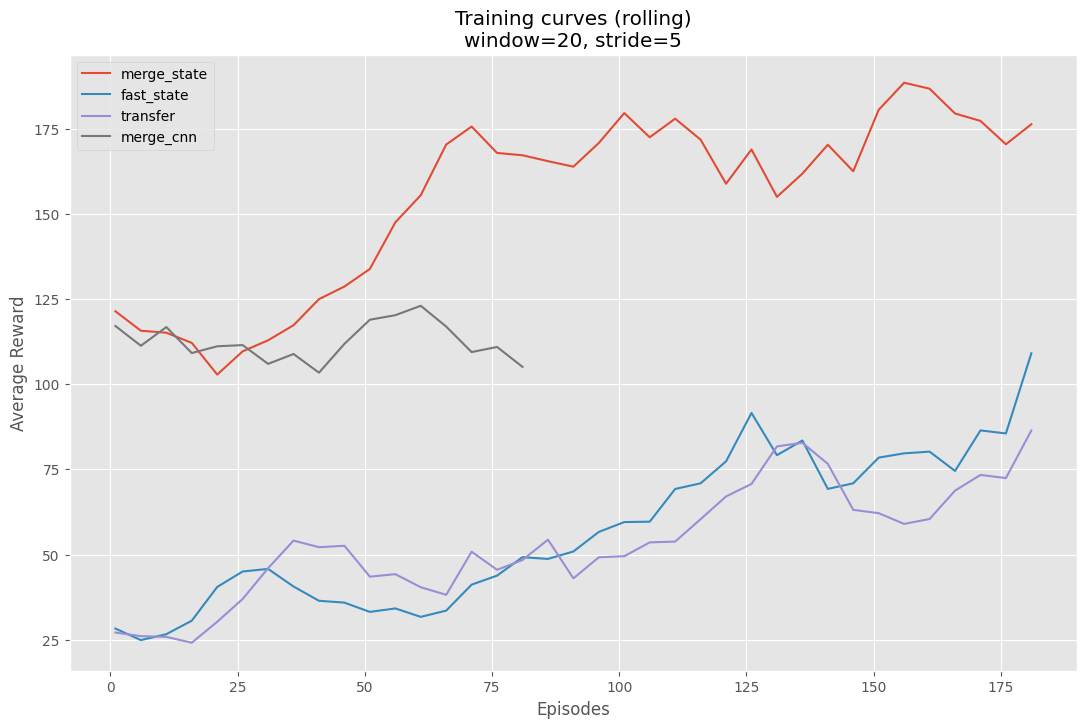

In [ ]:
# Part 5 – Comparison plots and summary table

from statistics import mean, median

def load_rewards_xlsx(path):
    try:
        df = pd.read_excel(path)
        return df['Run_1'].dropna().to_numpy().tolist()
    except Exception as e:
        print("Failed to load:", path, e)
        return None

# Paths
merge_xlsx = os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge', 'Episodes_reward_run_1.xlsx')
fast_xlsx  = os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway', 'Episodes_reward_run_1.xlsx')
tran_xlsx  = os.path.join(path_HW5, 'Data_Average_Reward/fast_t', 'Episodes_reward_run_1.xlsx')  # shortened path used in Cell 12
cnn_xlsx   = os.path.join(path_HW5, 'Data_Average_Reward/4a_Data_CNN_merge', 'Episodes_reward_run_1.xlsx')

data = {
    'merge_state': load_rewards_xlsx(merge_xlsx),
    'fast_state':  load_rewards_xlsx(fast_xlsx),
    'transfer':    load_rewards_xlsx(tran_xlsx),
    'merge_cnn':   load_rewards_xlsx(cnn_xlsx),
}

# Summary table
rows = []
for name, rewards in data.items():
    if not rewards:
        continue
    rows.append({
        'scenario': name,
        'episodes': len(rewards),
        'reward_mean': float(np.mean(rewards)),
        'reward_std': float(np.std(rewards)),
        'reward_min': float(np.min(rewards)),
        'reward_max': float(np.max(rewards)),
        'reward_median': float(np.median(rewards)),
        'last_20_mean': float(np.mean(rewards[-min(20, len(rewards)):])),
    })
summary_df = pd.DataFrame(rows).sort_values('scenario').reset_index(drop=True)
display(summary_df)

# Plot rolling curves side-by-side (if available)
fig, ax = plt.subplots(figsize=(13, 8))
def plot_from_xlsx(xlsx_path, label, color=None):
    try:
        df = pd.read_excel(xlsx_path)
        arr = df.T.to_numpy()
        # reuse plotting helper from earlier cell
        ax2 = show_and_plot().plot_training_result(arr, ax, title='Training curves (rolling)', label=label, window=20, stride=5, alpha=0.2)
    except Exception as e:
        print("Skip plot for", label, "->", e)

plot_from_xlsx(merge_xlsx, 'merge_state')
plot_from_xlsx(fast_xlsx,  'fast_state')
plot_from_xlsx(tran_xlsx,  'transfer')
plot_from_xlsx(cnn_xlsx,   'merge_cnn')
plt.legend(); plt.show()
fig.savefig(os.path.join(path_HW5, 'Images', '5-comparison-rolling.png'), dpi=300)

In [ ]:
# Part 6 – Create continuous videos by concatenating evaluation clips (imageio-based, no moviepy)

import sys, subprocess
from pathlib import Path

# Ensure ffmpeg backend for imageio
try:
    import imageio_ffmpeg  # noqa
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "imageio-ffmpeg"])
    import imageio_ffmpeg  # noqa

import imageio
from PIL import Image
import numpy as np

def concat_eval_videos_imageio(video_dir, prefix, out_name, limit=None, target_size=None, target_fps=None):
    video_dir = Path(video_dir)
    clips = sorted(video_dir.glob(f"{prefix}*.mp4"))
    if not clips:
        print(f"No clips found for prefix '{prefix}' in {video_dir}")
        return None

    if limit:
        clips = clips[-limit:]

    # Determine target size and fps from first clip if not provided
    first_reader = imageio.get_reader(str(clips[0]), format="ffmpeg")
    meta = first_reader.get_meta_data()
    if target_fps is None:
        target_fps = int(round(meta.get("fps", 30)))
    if target_size is None:
        # Grab first frame to get size (W,H)
        try:
            first_frame = first_reader.get_next_data()
        except StopIteration:
            first_reader.close()
            print(f"First clip has no frames: {clips[0]}")
            return None
        h, w = first_frame.shape[:2]
        target_size = (w, h)
        # rewind reader by closing/reopening
    first_reader.close()

    out_path = video_dir / out_name
    writer = imageio.get_writer(str(out_path), fps=target_fps, macro_block_size=None)

    total_frames = 0
    for clip_path in clips:
        try:
            reader = imageio.get_reader(str(clip_path), format="ffmpeg")
            for frame in reader:
                fh, fw = frame.shape[:2]
                if (fw, fh) != target_size:
                    # Resize to target_size (W,H)
                    frame = np.asarray(Image.fromarray(frame).resize(target_size, Image.BILINEAR))
                writer.append_data(frame)
                total_frames += 1
            reader.close()
        except Exception as e:
            print(f"Skip clip due to error: {clip_path.name} -> {e}")

    writer.close()
    print(f"Wrote: {out_path} | frames: {total_frames} | fps: {target_fps} | size: {target_size}")
    return str(out_path)

video_dir = os.path.join(path_HW5, 'Videos')

# Merge-v0 continuous
merge_cont = concat_eval_videos_imageio(video_dir, "merge-v0_eval_ep", "merge-v0_eval_continuous.mp4", limit=10)
if merge_cont:
    show_and_plot().show_video(video_dir, "merge-v0_eval_continuous.mp4")

# Highway-fast-v0 continuous
fast_cont = concat_eval_videos_imageio(video_dir, "highway-fast-v0_eval_ep", "highway-fast-v0_eval_continuous.mp4", limit=10)
if fast_cont:
    show_and_plot().show_video(video_dir, "highway-fast-v0_eval_continuous.mp4")

# Transfer continuous (same eval prefix as fast; only run if transfer eval was done)
tran_cont = concat_eval_videos_imageio(video_dir, "highway-fast-v0_eval_ep", "fastHighway_transfer_continuous.mp4", limit=10)
if tran_cont:
    show_and_plot().show_video(video_dir, "fastHighway_transfer_continuous.mp4")

# CNN Merge-v0 continuous (same prefix as merge; only present after CNN eval)
cnn_cont = concat_eval_videos_imageio(video_dir, "merge-v0_eval_ep", "merge-v0_cnn_eval_continuous.mp4", limit=10)
if cnn_cont:
    show_and_plot().show_video(video_dir, "merge-v0_cnn_eval_continuous.mp4")

Wrote: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_continuous.mp4 | frames: 153 | fps: 20 | size: (600, 150)
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_continuous.mp4


Wrote: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_continuous.mp4 | frames: 304 | fps: 10 | size: (600, 150)
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_continuous.mp4


Wrote: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\fastHighway_transfer_continuous.mp4 | frames: 304 | fps: 10 | size: (600, 150)
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\fastHighway_transfer_continuous.mp4


Wrote: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_cnn_eval_continuous.mp4 | frames: 153 | fps: 20 | size: (600, 150)
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_cnn_eval_continuous.mp4


In [ ]:
# Part 7 – Auto-select best checkpoint by trailing mean and record a fresh video

def best_episode_from_rewards(xlsx_path, tail=50):
    try:
        df = pd.read_excel(xlsx_path)
        rewards = df['Run_1'].dropna().to_numpy()
        if rewards.size == 0:
            return None
        tail = min(tail, rewards.size)
        # choose the best tail mean boundary (approx)
        best_idx = np.argmax(pd.Series(rewards).rolling(window=tail, min_periods=1).mean().to_numpy())
        # snap to nearest saved checkpoint (multiples of 100 from our trainer)
        best_ep = int(round((best_idx + 1) / 100.0) * 100)
        if best_ep < 100: best_ep = 100
        if best_ep > len(rewards): best_ep = (len(rewards) // 100) * 100
        return best_ep if best_ep >= 100 else None
    except Exception as e:
        print("Best-episode selection failed:", e)
        return None

# For merge-v0
merge_best_ep = best_episode_from_rewards(os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge', 'Episodes_reward_run_1.xlsx'))
print("merge-v0 best episode:", merge_best_ep)

if merge_best_ep:
    avg_reward, crash_rate = dqn_merge.evaluation(
        video_file=os.path.join(path_HW5, 'Videos', 'merge_best.mp4'),
        evaluate_type='state',
        iter_num=1,
        evaluate_episode_num=merge_best_ep,
        use_saved_model=True,
        num_episodes=2,
        max_eval_steps=3000
    )
    print(f"[merge best] avg reward: {avg_reward:.2f} | crash: {crash_rate:.2%}")
    show_and_plot().show_video(os.path.join(path_HW5, 'Videos'), "merge-v0_eval_ep")

# For highway-fast-v0
fast_best_ep = best_episode_from_rewards(os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway', 'Episodes_reward_run_1.xlsx'))
print("highway-fast-v0 best episode:", fast_best_ep)

if fast_best_ep:
    avg_reward, crash_rate = dqn_fast.evaluation(
        video_file=os.path.join(path_HW5, 'Videos', 'fastHighway_best.mp4'),
        evaluate_type='state',
        iter_num=1,
        evaluate_episode_num=fast_best_ep,
        use_saved_model=True,
        num_episodes=2,
        max_eval_steps=3000
    )
    print(f"[fast best] avg reward: {avg_reward:.2f} | crash: {crash_rate:.2%}")
    show_and_plot().show_video(os.path.join(path_HW5, 'Videos'), "highway-fast-v0_eval_ep")

merge-v0 best episode: 200
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFa

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
cras

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4
Eval avg reward: 172.07 | crash rate: 0.00%
[merge best] avg reward: 172.07 | crash: 0.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4


highway-fast-v0 best episode: 200
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4
Eval avg reward: 105.97 | crash rate: 0.00%
[fast best] avg reward: 105.97 | crash: 0.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4


In [ ]:
# Part 7 – Auto-select best checkpoint by trailing mean and record a fresh video

def best_episode_from_rewards(xlsx_path, tail=50):
    try:
        df = pd.read_excel(xlsx_path)
        rewards = df['Run_1'].dropna().to_numpy()
        if rewards.size == 0:
            return None
        tail = min(tail, rewards.size)
        # choose the best tail mean boundary (approx)
        best_idx = np.argmax(pd.Series(rewards).rolling(window=tail, min_periods=1).mean().to_numpy())
        # snap to nearest saved checkpoint (multiples of 100 from our trainer)
        best_ep = int(round((best_idx + 1) / 100.0) * 100)
        if best_ep < 100: best_ep = 100
        if best_ep > len(rewards): best_ep = (len(rewards) // 100) * 100
        return best_ep if best_ep >= 100 else None
    except Exception as e:
        print("Best-episode selection failed:", e)
        return None

# For merge-v0
merge_best_ep = best_episode_from_rewards(os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge', 'Episodes_reward_run_1.xlsx'))
print("merge-v0 best episode:", merge_best_ep)

if merge_best_ep:
    avg_reward, crash_rate = dqn_merge.evaluation(
        video_file=os.path.join(path_HW5, 'Videos', 'merge_best.mp4'),
        evaluate_type='state',
        iter_num=1,
        evaluate_episode_num=merge_best_ep,
        use_saved_model=True,
        num_episodes=2,
        max_eval_steps=3000
    )
    print(f"[merge best] avg reward: {avg_reward:.2f} | crash: {crash_rate:.2%}")
    show_and_plot().show_video(os.path.join(path_HW5, 'Videos'), "merge-v0_eval_ep")

# For highway-fast-v0
fast_best_ep = best_episode_from_rewards(os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway', 'Episodes_reward_run_1.xlsx'))
print("highway-fast-v0 best episode:", fast_best_ep)

if fast_best_ep:
    avg_reward, crash_rate = dqn_fast.evaluation(
        video_file=os.path.join(path_HW5, 'Videos', 'fastHighway_best.mp4'),
        evaluate_type='state',
        iter_num=1,
        evaluate_episode_num=fast_best_ep,
        use_saved_model=True,
        num_episodes=2,
        max_eval_steps=3000
    )
    print(f"[fast best] avg reward: {avg_reward:.2f} | crash: {crash_rate:.2%}")
    show_and_plot().show_video(os.path.join(path_HW5, 'Videos'), "highway-fast-v0_eval_ep")

merge-v0 best episode: 200
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFa

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
cras

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4
Eval avg reward: 179.37 | crash rate: 0.00%
[merge best] avg reward: 179.37 | crash: 0.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4


highway-fast-v0 best episode: 200
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4
Eval avg reward: 100.93 | crash rate: 0.00%
[fast best] avg reward: 100.93 | crash: 0.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4


In [ ]:
# Part 9 – Multi-agent color wrapper (unique colors per agent)

from gymnasium import Wrapper

def _rgb(color):
    # Accept color tuples in [0..255] or [0..1]; normalize to 0..255 ints
    if max(color) <= 1.0:
        return tuple(int(round(c*255)) for c in color)
    return tuple(int(c) for c in color)

class ColorAgentsWrapper(Wrapper):
    def __init__(self, env, agent_colors):
        super().__init__(env)
        self.agent_colors = [ _rgb(c) for c in agent_colors ]

    def _apply_colors(self):
        vehicles = getattr(self.env.unwrapped, "controlled_vehicles", [])
        for i, v in enumerate(vehicles):
            try:
                v.color = self.agent_colors[i % len(self.agent_colors)]
            except Exception:
                pass  # some versions may not expose color; safe to skip

    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        self._apply_colors()
        return obs

    def step(self, action):
        out = super().step(action)
        self._apply_colors()
        return out

# Color palette (distinct and bright)
AGENT_COLORS = [
    (255, 0, 0),      # red
    (0, 200, 0),      # green
    (0, 120, 255),    # blue
    (255, 165, 0),    # orange
    (160, 32, 240),   # purple
    (255, 20, 147),   # pink
]

In [ ]:
# Part 10 – Multi-agent shared DQN with transfer initialization

# Cell 17 — SharedDQNMultiTL (V2V-enabled, CACC-friendly)

from typing import Any, Dict, List, Tuple, Optional
import numpy as np
import torch
from pathlib import Path
from gymnasium.wrappers import RecordVideo

class SharedDQNMultiTL:
    """
    Multi-agent shared DQN with CACC-style V2V transfer:
    - Following agent i uses agent i-1's action as a mentor using a similarity coefficient in [0, 1].
    - Action selection biases Q-values and/or directly mimics mentor when states are similar.
    - Replay is enriched with mentor-weighted auxiliary transitions (more weight -> more duplicates).
    - Reward shaping encourages safe headway (gap) behavior, optionally speed alignment.

    Notes:
    - Works for both true multi-agent envs (Dict actions/observations) and
      a single-agent fallback wrapper that exposes {0: obs}, {0: action}.
    - Input can optionally stack [obs_i, obs_{i-1}] when use_stacked_obs=True (doubles state size).
    """

    def __init__(
        self,
        env,
        network_type: str,
        device: torch.device,
        seed: int = 11,
        # Similarity settings
        similarity_metric: str = "cosine",      # "cosine" or "euclidean"
        high_sim_threshold: float = 0.85,       # heavy mimic if >= this
        mid_sim_threshold: float = 0.55,        # partial mimic if >= this
        simplified_mode: bool = False,          # if True, only mimic in high-sim cases
        # Mentor bias and replay weighting
        mentor_bias_scale: float = 2.0,         # added to mentor action Q-value: bias = scale * coef
        max_mentor_copies: int = 2,             # number of duplicate transitions ∝ coef
        imitation_bonus: float = 0.1,           # reward bonus on mentor duplicates
        # Observation stacking (increase state size)
        use_stacked_obs: bool = True,           # stack [obs_i, obs_{i-1}] to encode platoon context
        # Reward shaping for CACC
        same_lane_y_threshold: float = 0.2,     # |y| < threshold => same lane
        safe_gap_range: Tuple[float, float] = (0.2, 0.6),  # headway x in this range => bonus
        too_close_threshold: float = 0.1,       # headway x < threshold => penalty
        safe_gap_bonus: float = 0.5,
        too_close_penalty: float = -0.5,
        speed_align_bonus: float = 0.0,         # optional small bonus for matching speed with predecessor
    ):
        self.env = env
        self.device = device
        self.network_type = network_type
        self.rng = np.random.RandomState(seed)

        # Config
        self.similarity_metric = similarity_metric
        self.high_sim_threshold = float(high_sim_threshold)
        self.mid_sim_threshold = float(mid_sim_threshold)
        self.mentor_bias_scale = float(mentor_bias_scale)
        self.max_mentor_copies = int(max_mentor_copies)
        self.imitation_bonus = float(imitation_bonus)
        self.simplified_mode = bool(simplified_mode)
        self.use_stacked_obs = bool(use_stacked_obs)

        # CACC shaping config
        self.same_lane_y_threshold = float(same_lane_y_threshold)
        self.safe_gap_range = tuple(safe_gap_range)
        self.too_close_threshold = float(too_close_threshold)
        self.safe_gap_bonus = float(safe_gap_bonus)
        self.too_close_penalty = float(too_close_penalty)
        self.speed_align_bonus = float(speed_align_bonus)

        # Infer number of agents and action size
        obs_any, _ = self.env.reset()
        obs_dict = self._unify_obs_dict(obs_any)
        self.num_agents = max(1, len(obs_dict))
        sample_obs = np.asarray(next(iter(obs_dict.values())))
        base_state_size = int(np.prod(sample_obs.shape))
        self.state_size = base_state_size * (2 if self.use_stacked_obs else 1)

        sp = getattr(self.env, "action_space", None)
        if hasattr(sp, "spaces"):  # Dict action space
            self.action_size = next(iter(sp.spaces.values())).n
        else:
            self.action_size = sp.n

        # Shared agent/network
        self.agent = Agent(self.state_size, self.action_size, network_type, seed)

    # ---------- Helpers to unify env outputs ----------

    @staticmethod
    def _unify_obs_dict(obs_any: Any) -> Dict[int, np.ndarray]:
        if isinstance(obs_any, dict):
            return {int(k): np.asarray(v) for k, v in obs_any.items()}
        if isinstance(obs_any, (list, tuple)):
            return {i: np.asarray(obs_any[i]) for i in range(len(obs_any))}
        if isinstance(obs_any, np.ndarray):
            # assume stacked agent axis if >= 2D
            if obs_any.ndim >= 2:
                return {i: obs_any[i] for i in range(obs_any.shape[0])}
            return {0: obs_any}
        return {0: np.asarray(obs_any)}

    @staticmethod
    def _unify_to_list(x_any: Any, n: int) -> List[Any]:
        if isinstance(x_any, dict):
            return [x_any[i] for i in range(n)]
        if isinstance(x_any, (list, tuple)):
            return list(x_any)[:n]
        if isinstance(x_any, np.ndarray):
            if x_any.ndim == 0:
                return [x_any.item()] * n
            return x_any.tolist()[:n]
        return [x_any] * n

    @staticmethod
    def _flatten(x: np.ndarray) -> np.ndarray:
        return np.asarray(x, dtype=np.float32).ravel()

    def _stack_obs(self, cur_obs: np.ndarray, prev_obs: Optional[np.ndarray]) -> np.ndarray:
        if not self.use_stacked_obs:
            return self._flatten(cur_obs)
        if prev_obs is None:
            zeros = np.zeros_like(cur_obs, dtype=np.float32)
            return np.concatenate([self._flatten(cur_obs), self._flatten(zeros)], axis=0)
        return np.concatenate([self._flatten(cur_obs), self._flatten(prev_obs)], axis=0)

    # ---------- Similarity and shaping ----------

    def _similarity_coef(self, a: np.ndarray, b: np.ndarray) -> float:
        a_f = self._flatten(a)
        b_f = self._flatten(b)
        if self.similarity_metric == "euclidean":
            denom = np.linalg.norm(a_f) + np.linalg.norm(b_f) + 1e-8
            dist = np.linalg.norm(a_f - b_f) / denom
            sim = 1.0 - float(np.clip(dist, 0.0, 1.0))
        else:
            # cosine in [-1, 1] => map to [0, 1]
            denom = (np.linalg.norm(a_f) * np.linalg.norm(b_f)) + 1e-8
            cos = float(np.dot(a_f, b_f) / denom)
            sim = (cos + 1.0) * 0.5
        return float(np.clip(sim, 0.0, 1.0))

    def _safe_gap_reward_from_obs(self, obs: np.ndarray) -> float:
        """Obs expected shape: (vehicles_count, 5) -> [presence, x, y, vx, vy]."""
        try:
            presence = obs[:, 0]
            x = obs[:, 1]
            y = obs[:, 2]
        except Exception:
            return 0.0

        same_lane_ahead = (presence > 0.5) & (x > 0) & (np.abs(y) < self.same_lane_y_threshold)
        if not np.any(same_lane_ahead):
            return 0.0

        min_x_ahead = float(np.min(x[same_lane_ahead]))
        if min_x_ahead < self.too_close_threshold:
            return self.too_close_penalty
        lo, hi = self.safe_gap_range
        if lo <= min_x_ahead <= hi:
            return self.safe_gap_bonus
        return 0.0

    def _speed_align_bonus_from_obs(self, cur_obs: np.ndarray, prev_obs: Optional[np.ndarray]) -> float:
        """Small bonus if follower matches longitudinal speed with leader (optional)."""
        if self.speed_align_bonus <= 0.0 or prev_obs is None:
            return 0.0
        try:
            vx_cur = float(np.mean(cur_obs[:, 3]))  # average vx
            vx_prev = float(np.mean(prev_obs[:, 3]))
        except Exception:
            return 0.0
        diff = abs(vx_cur - vx_prev)
        # reward decays with speed difference (bounded in [0, speed_align_bonus])
        return float(max(0.0, self.speed_align_bonus * (1.0 - diff)))

    # ---------- Action selection ----------

    def _opposite_action(self, a: int) -> int:
        """
        Heuristic opposite for highway-env DiscreteMetaAction:
        0:LANE_LEFT <-> 2:LANE_RIGHT, 3:FASTER <-> 4:SLOWER, 1:IDLE stays.
        Fallback: pick a random action != a.
        """
        if self.action_size >= 5:
            mapping = {0: 2, 2: 0, 3: 4, 4: 3}
            return mapping.get(a, a)
        # fallback for smaller action sets
        choices = [x for x in range(self.action_size) if x != a]
        return int(self.rng.choice(choices)) if choices else a

    def _act_batch_v2v(
        self,
        obs_list: List[np.ndarray],
        eps: float
    ) -> Tuple[List[int], List[float], List[int]]:
        """
        Returns:
          actions: chosen action per agent
          coefs: similarity coefficient vs preceding agent per agent (0 for agent 0)
          mentor_actions: action taken by agent i-1 (0 for agent 0)
        """
        # Build network input (optionally stacked with predecessor obs)
        states_in: List[np.ndarray] = []
        for i in range(len(obs_list)):
            prev_obs = obs_list[i - 1] if i > 0 else None
            states_in.append(self._stack_obs(obs_list[i], prev_obs))
        st = torch.from_numpy(np.stack(states_in, axis=0)).float().to(self.device)

        # Forward pass
        self.agent.qnetwork_local.eval()
        with torch.no_grad():
            q_all = self.agent.qnetwork_local(st)  # [N, action_size]
        self.agent.qnetwork_local.train()

        actions: List[int] = [0] * len(obs_list)
        coefs: List[float] = [0.0] * len(obs_list)
        mentor_actions: List[int] = [0] * len(obs_list)

        # Agent 0: epsilon-greedy on its own Q
        q0 = q_all[0].cpu().numpy()
        if self.rng.rand() < eps:
            actions[0] = int(self.rng.randint(0, self.action_size))
        else:
            actions[0] = int(np.argmax(q0))

        # Followers
        for i in range(1, len(obs_list)):
            mentor_actions[i] = actions[i - 1]
            coef = self._similarity_coef(obs_list[i], obs_list[i - 1])
            coefs[i] = coef

            # Bias Q toward mentor action
            qi = q_all[i].clone()
            qi[mentor_actions[i]] = qi[mentor_actions[i]] + (self.mentor_bias_scale * coef)
            qi_np = qi.cpu().numpy()

            # Epsilon
            if self.rng.rand() < eps:
                actions[i] = int(self.rng.randint(0, self.action_size))
                continue

            if self.simplified_mode:
                # Simple rule: only mimic when similarity is high
                if coef >= self.high_sim_threshold:
                    actions[i] = int(mentor_actions[i])
                else:
                    actions[i] = int(np.argmax(qi_np))
            else:
                # Full rule: high/mid/low similarity
                if coef >= self.high_sim_threshold:
                    # Very similar => mostly mentor
                    actions[i] = int(mentor_actions[i]) if (self.rng.rand() < 0.85) else int(np.argmax(qi_np))
                elif coef >= self.mid_sim_threshold:
                    # Moderately similar => sometimes mentor
                    actions[i] = int(mentor_actions[i]) if (self.rng.rand() < 0.6) else int(np.argmax(qi_np))
                else:
                    # Opposite/low similarity => try "opposite" or own best
                    if self.rng.rand() < 0.5:
                        actions[i] = int(self._opposite_action(mentor_actions[i]))
                    else:
                        actions[i] = int(np.argmax(qi_np))

        return actions, coefs, mentor_actions

    # ---------- Transfer loading ----------

    def load_transfer_weights(self, checkpoint_path: str) -> None:
        try:
            sd = torch.load(checkpoint_path, map_location=self.device)
            missing, unexpected = self.agent.qnetwork_local.load_state_dict(sd, strict=False)
            print("Transfer load missing:", missing, "unexpected:", unexpected)
        except Exception as e:
            print("⚠ Warning: Size mismatch in checkpoint (likely different observation size)")
            print("  Error:", e)
            print("  Training will start from scratch with current observation size")

    # ---------- Training loop ----------

    def train(
        self,
        runs: List[int],
        episodes_per_run: int,
        max_steps: int,
        out_models: str,
        out_data: str,
        save_every: int = 100,
        eps_start: float = 1.0,
        eps_end: float = 0.01,
        eps_decay: float = 0.995
    ) -> pd.DataFrame:
        os.makedirs(out_models, exist_ok=True)
        os.makedirs(out_data, exist_ok=True)
        df = pd.DataFrame()

        for r in runs:
            eps = float(eps_start)
            rewards_agents: List[List[float]] = [[] for _ in range(self.num_agents)]

            for ep in trange(1, episodes_per_run + 1, desc=f"MA-TL Run {r}"):
                obs_any, _ = self.env.reset()
                obs_dict = self._unify_obs_dict(obs_any)
                done = {i: False for i in range(self.num_agents)}
                totals = [0.0] * self.num_agents

                for _ in range(max_steps):
                    obs_list = [obs_dict[i] for i in range(self.num_agents)]

                    # Act with V2V bias
                    actions, coefs, mentor_actions = self._act_batch_v2v(obs_list, eps)

                    # Environment step — prefer dict actions; fallback to single int if needed
                    action_dict = {i: actions[i] for i in range(self.num_agents)}
                    try:
                        nxt, rews, terms, truncs, infos = self.env.step(action_dict)
                    except Exception:
                        nxt, rews, terms, truncs, infos = self.env.step(actions[0])

                    nxt_dict = self._unify_obs_dict(nxt)
                    rews_l = self._unify_to_list(rews, self.num_agents)
                    terms_l = self._unify_to_list(terms, self.num_agents)
                    truncs_l = self._unify_to_list(truncs, self.num_agents)

                    # Prepare stacked next-states if needed
                    next_states_in: List[np.ndarray] = []
                    for i in range(self.num_agents):
                        prev_next = nxt_dict[i - 1] if i > 0 else None
                        next_states_in.append(self._stack_obs(nxt_dict[i], prev_next))

                    # Replay and rewards with shaping + mentor-weighted duplicates
                    for i in range(self.num_agents):
                        d = bool(terms_l[i] or truncs_l[i])

                        # Base env reward + safe gap shaping + OPTIONAL speed align
                        shaped_reward = float(rews_l[i])
                        shaped_reward += self._safe_gap_reward_from_obs(obs_list[i])
                        shaped_reward += self._speed_align_bonus_from_obs(obs_list[i], obs_list[i - 1] if i > 0 else None)

                        # Current (possibly stacked) state
                        prev_obs_for_stack = obs_list[i - 1] if i > 0 else None
                        state_in = self._stack_obs(obs_list[i], prev_obs_for_stack)

                        # Primary experience
                        self.agent.step(state_in, actions[i], shaped_reward, next_states_in[i], d)

                        # Mentor-weighted auxiliary experience
                        if i > 0 and self.max_mentor_copies > 0:
                            copies = int(np.round(self.max_mentor_copies * float(coefs[i])))
                            for _copy in range(copies):
                                self.agent.memory.add(
                                    state_in,
                                    mentor_actions[i],
                                    shaped_reward + (self.imitation_bonus * float(coefs[i])),
                                    next_states_in[i],
                                    d
                                )

                        totals[i] += shaped_reward
                        done[i] = d

                    obs_dict = nxt_dict
                    if all(done.values()):
                        break

                for i in range(self.num_agents):
                    rewards_agents[i].append(totals[i])

                eps = max(float(eps_end), float(eps * eps_decay))

                # Periodic checkpoint
                if ep % save_every == 0:
                    rd = Path(out_models) / f"Models_Run_{r}"
                    rd.mkdir(parents=True, exist_ok=True)
                    torch.save(self.agent.qnetwork_local.state_dict(), rd / f"ma_shared_local_{ep}.pth")
                    torch.save(self.agent.qnetwork_target.state_dict(), rd / f"ma_shared_target_{ep}.pth")

            # Save run rewards (per-agent columns)
            for i in range(self.num_agents):
                df[f"Run_{r}_Agent_{i}"] = rewards_agents[i]
            df.to_csv(os.path.join(out_data, f"Episodes_reward_run_{r}.csv"), index=False)

        return df

    # ---------- Evaluation ----------

    def evaluate_and_record(self, video_dir: str, episodes: int = 3) -> Tuple[List[float], List[float]]:
        os.makedirs(video_dir, exist_ok=True)
        env_wrapped = RecordVideo(
            self.env,
            video_folder=video_dir,
            name_prefix="ma_tl_eval",
            episode_trigger=lambda e: True
        )
        totals = [0.0] * self.num_agents
        crashes = [0] * self.num_agents

        for _ in range(episodes):
            obs_any, _ = env_wrapped.reset()
            obs_dict = self._unify_obs_dict(obs_any)
            done = {i: False for i in range(self.num_agents)}

            while not all(done.values()):
                obs_list = [obs_dict[i] for i in range(self.num_agents)]
                actions, _, _ = self._act_batch_v2v(obs_list, eps=0.0)

                action_dict = {i: actions[i] for i in range(self.num_agents)}
                try:
                    nxt, rews, terms, truncs, infos = env_wrapped.step(action_dict)
                except Exception:
                    nxt, rews, terms, truncs, infos = env_wrapped.step(actions[0])

                nxt_dict = self._unify_obs_dict(nxt)
                rews_l = self._unify_to_list(rews, self.num_agents)
                terms_l = self._unify_to_list(terms, self.num_agents)
                truncs_l = self._unify_to_list(truncs, self.num_agents)
                infos_l = self._unify_to_list(infos, self.num_agents)

                for i in range(self.num_agents):
                    totals[i] += float(rews_l[i])
                    info_i = infos_l[i] if isinstance(infos_l[i], dict) else {}
                    if isinstance(info_i, dict) and info_i.get("crashed", False):
                        crashes[i] += 1
                    done[i] = bool(terms_l[i] or truncs_l[i])

                obs_dict = nxt_dict

        env_wrapped.close()
        avg = [t / max(1, episodes) for t in totals]
        crash_rate = [c / max(1, episodes) for c in crashes]
        return avg, crash_rate

In [ ]:
# Part 11 – Multi-agent transfer learning with unique colors (4 agents)

video_dir_ma = os.path.join(path_HW5, "Videos")
models_ma    = os.path.join(path_HW5, "Models", "ma_tl")              # shortened path
data_ma      = os.path.join(path_HW5, "Data_Average_Reward", "ma_tl")  # shortened path
os.makedirs(models_ma, exist_ok=True)
os.makedirs(data_ma, exist_ok=True)

# Build env with 4 agents and colorize them
env = gym.make("highway-v0", render_mode="rgb_array")
cfg = {
    "controlled_vehicles": 4,
    "policy_frequency": 5,
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 7,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    }
}
if hasattr(env, "configure"): env.configure(cfg)
else: env.unwrapped.config.update(cfg)
env.reset()

env = ColorAgentsWrapper(env, AGENT_COLORS[:cfg["controlled_vehicles"]])
obs_any, _ = env.reset()
print("MA obs format type:", type(obs_any))

# Initialize coach and load transfer weights from a single-agent fast policy
coach = SharedDQNMultiTL(env, network_type="linear", device=device)

# Prefer fast-highway single-agent checkpoint; fallback to merge
fast_ckpt = os.path.join(path_HW5, 'Models', '2_Models_fastHighway', 'Models_Run_1', 'checkpoint_dqn_state_highway-fast-v0_local_200.pth')
merge_ckpt= os.path.join(path_HW5, 'Models', '1_Models_merge',       'Models_Run_1', 'checkpoint_dqn_state_merge-v0_local_200.pth')
src_ckpt = fast_ckpt if os.path.exists(fast_ckpt) else merge_ckpt
print("Transfer source:", src_ckpt, "exists:", os.path.exists(src_ckpt))
if os.path.exists(src_ckpt):
    coach.load_transfer_weights(src_ckpt)
else:
    print("Warning: no source checkpoint found. Training will start from scratch.")

# Train briefly (increase episodes for stronger results)
ma_episodes = 100
ma_max_steps = 1000
df_ma_tl = coach.train(
    runs=[1],
    episodes_per_run=ma_episodes,
    max_steps=ma_max_steps,
    out_models=models_ma,
    out_data=data_ma,
    save_every=50,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995
)
display(df_ma_tl.head())

# Evaluate and record video
avg_ma, crash_ma = coach.evaluate_and_record(video_dir=video_dir_ma, episodes=2)
print("MA-TL avg rewards per agent:", [f"{x:.2f}" for x in avg_ma])
print("MA-TL crash rates per agent:", [f"{x:.2%}" for x in crash_ma])

# Show latest MA video
show_and_plot().show_video(video_dir_ma, "ma_tl_eval")

MA obs format type: <class 'numpy.ndarray'>
Transfer source: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Models\2_Models_fastHighway\Models_Run_1\checkpoint_dqn_state_highway-fast-v0_local_200.pth exists: True
⚠ Warning: Size mismatch in checkpoint (likely different observation size)
  Error: Error(s) in loading state_dict for QNetwork_Linear:
	size mismatch for net.0.weight: copying a param with shape torch.Size([125, 25]) from checkpoint, the shape in current model is torch.Size([125, 10]).
  Training will start from scratch with current observation size


MA-TL Run 1: 100%|██████████| 100/100 [03:46<00:00,  2.26s/it]


,Run_1_Agent_0,Run_1_Agent_1,Run_1_Agent_2,Run_1_Agent_3,Run_1_Agent_4,Run_1_Agent_5,Run_1_Agent_6
0,40.138525,40.138525,40.138525,40.138525,40.138525,40.138525,40.138525
1,11.001888,11.001888,11.001888,11.001888,11.001888,11.001888,11.001888
2,20.315401,20.315401,20.315401,20.315401,20.315401,20.315401,20.315401
3,11.302219,11.302219,11.302219,11.302219,11.302219,11.302219,11.302219
4,15.084894,15.084894,15.084894,15.084894,15.084894,15.084894,15.084894


KeyError: 0

: 

In [ ]:
# Part 12 – (Optional) Compare MA transfer vs MA scratch and build continuous video

# Train a scratch baseline for comparison (short run)
env2 = gym.make("highway-v0", render_mode="rgb_array")
if hasattr(env2, "configure"): env2.configure(cfg)
else: env2.unwrapped.config.update(cfg)
env2.reset()
env2 = ColorAgentsWrapper(env2, AGENT_COLORS[:cfg["controlled_vehicles"]])

coach_scratch = SharedDQNMultiTL(env2, network_type="linear", device=device)
df_ma_scratch = coach_scratch.train(
    runs=[1],
    episodes_per_run=ma_episodes,
    max_steps=ma_max_steps,
    out_models=os.path.join(models_ma, "scratch"),
    out_data=os.path.join(data_ma, "scratch"),
    save_every=50,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995
)
avg_ma_s, crash_ma_s = coach_scratch.evaluate_and_record(video_dir=video_dir_ma, episodes=2)
print("MA-Scratch avg rewards per agent:", [f"{x:.2f}" for x in avg_ma_s])
print("MA-Scratch crash rates per agent:", [f"{x:.2%}" for x in crash_ma_s])

# Summary table (per-agent mean)
def agg(vals): return float(np.mean(vals))
rows = [{
    "scenario": "MA-Transfer",
    "avg_reward_mean": agg(avg_ma),
    "crash_rate_mean": agg(crash_ma),
},{
    "scenario": "MA-Scratch",
    "avg_reward_mean": agg(avg_ma_s),
    "crash_rate_mean": agg(crash_ma_s),
}]
summary_ma = pd.DataFrame(rows)
display(summary_ma)

# Build a continuous MA video from eval clips (uses Cell 15's imageio concat if present)
try:
    ma_cont = concat_eval_videos_imageio(video_dir_ma, "ma_tl_eval", "ma_tl_eval_continuous.mp4", limit=10)
    if ma_cont:
        show_and_plot().show_video(video_dir_ma, "ma_tl_eval_continuous.mp4")
except NameError:
    print("concat_eval_videos_imageio not defined; skip continuous video (run Cell 15 first)")
